# Geocookies Analysis

In [161]:
ROOT = "data/desktop/detectedBanner" # path of the crawl data

## Package imports

In [162]:
# imports

%matplotlib inline
import pandas as pd
import numpy as np
import sqlite3
import os
from bs4 import BeautifulSoup as bs
import re
from functools import reduce
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
sns.set_theme()
import warnings
import scipy.stats
import scikit_posthocs as sp
from publicsuffix2 import PublicSuffixList

import matplotlib.patches as mpatches
import pingouin as pg

from statannotations.Annotator import Annotator

import json
import csv
import math

import pprint
pp = pprint.PrettyPrinter(indent=4)

psl = PublicSuffixList()
warnings.filterwarnings('ignore')
# %config Completer.use_jedi = False

## Initial variables

In [163]:
# plots configs

plt.rc('text', usetex=True)

plt.rcParams['font.size'] = 9
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.dpi"] = 3000
plt.rcParams["figure.autolayout"] = True
plt.rcParams["text.usetex"] = True
# plt.rcParams['figure.figsize'] = 3.35,7.03
single_col_width = 3.35
double_col_width = 7.03
sns.set_style("white")

In [164]:
# initializing vars
# 'eu-central-1' , 
FIG_DIR = './files/figs'
INPUT_DIR = './files/inputs'
CSV_DIR = './files/csv'
# AWS_names = ['eu-central-1' , 'eu-north-1', 'us-east-1', 'us-west-1', 'ap-south-1', 'sa-east-1', 'af-south-1', 'ap-southeast-2']
AWS_names = ['us-east-1']
AWS_to_loc = {'eu-central-1': "Germany" , 'eu-north-1': "Sweden", 'us-east-1': "US East", 'us-west-1': "US West", 'ap-south-1': "India", 'sa-east-1': "Brazil", 'af-south-1': "South Africa", 'ap-southeast-2': "Australia"}
loc_to_AWS = {'Germany': "eu-central-1" , 'Sweden': "eu-north-1", 'US East': "us-east-1", 'US West': "us-west-1", 'India': "ap-south-1", 'Brazil': "sa-east-1", 'South Africa': "af-south-1", 'Australia': "ap-southeast-2"}
# locations = ['Germany', 'Sweden', 'US East', 'US West', 'India', 'Brazil', 'South Africa', 'Australia']
locations = ['US East']
EU_locs = ['Germany', 'Sweden']
nonEU_locs = ['US East', 'US West', 'India', 'Brazil', 'South Africa', 'Australia']

tranco_list = pd.read_csv(INPUT_DIR+'/Tranco5Nov.csv')
OFFSET_ACCEPT = 10000000
OFFSET_REJECT = 20000000
NUM_BATCH = 10

run_to_folder = {"desktop": "desktop", "mobile": "mobile-sc", "ccpa":"new-ccpa", "innerpages": "new-innerpages", "consistency": "consistency", "more-1k": "more--1iter-1k", "acc_rej_sc": "acc_rej_sc", "words_extraction": "more--1iter-10k-2", "sub": "sub/1", "sub2": "sub/22"}
new_runs = ["acc_rej_sc", "sub", "sub2"]

cookies_collect = True

# AWS_names = ['us-east-1']
# run_cat =    desktop    mobile-sc   ccpa
# eu_central = None, eu_north = None, us_east = None, us_west = None, ap_south = None
# sa_east = None, af_south = None, ap_southeast = None

In [165]:
runs = {}

## Setup functions

In [166]:

import pandas as pd
import matplotlib.pyplot as mpl

df = pd.read_csv('open-cookie-database.csv')

# # Group the data by Category and count the number of cookies in each Category
# category_counts = df['Category'].value_counts()

# display(category_counts)

# plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
# plt.title('Distribution of Cookies by Category Within Cookie Database')
# plt.axis('equal')
# plt.show()



# Create a dictionary with "Cookie / Data Key name" as keys and "Category" as values
cookie_category_dict = dict(zip(df['Cookie / Data Key name'], df['Category']))

# Print the dictionary
print(cookie_category_dict)


{'cookiePreferences': 'Functional', 'CookieConsent': 'Functional', 'CookieConsentBulkTicket': 'Functional', 'userlang': 'Functional', 'cookieconsent_variant': 'Functional', 'cookieconsent_system': 'Functional', 'cookieconsent_level': 'Functional', 'cookieconsent_seen': 'Functional', '_ga': 'Analytics', '_ga_': 'Analytics', '_gid': 'Analytics', '_gat': 'Analytics', '_dc_gtm_': 'Analytics', 'AMP_TOKEN': 'Analytics', '_gat_gtag_': 'Analytics', '_gac_': 'Marketing', '__utma': 'Analytics', '__utmt': 'Analytics', '__utmb': 'Analytics', '__utmc': 'Analytics', '__utmz': 'Analytics', '__utmv': 'Analytics', '__utmx': 'Analytics', '__utmxx': 'Analytics', '_GRECAPTCHA': 'Functional', 'S1': 'Analytics', 'C1': 'Analytics', 's_cc': 'Analytics', 's_sq': 'Analytics', 's_vi': 'Analytics', 's_fid': 'Analytics', 'fid': 'Analytics', 'demdex': 'Marketing', 'dextp': 'Marketing', 'dst': 'Marketing', '_dp': 'Marketing', 'aam_uuid': 'Marketing', 'AMCV_': 'Marketing', 'AMCVS_': 'Marketing', 'mbox': 'Marketing', 

In [167]:
# def print_cookies_with_different_categories(csv_file_path):
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(csv_file_path)

#     # Group the DataFrame by "Cookie / Data Key name" and filter groups with more than one unique "Category"
#     grouped = df.groupby('Cookie / Data Key name').filter(lambda x: x['Category'].nunique() > 1)

#     # Iterate through the groups and print the cookies with different categories
#     for _, group in grouped.groupby('Cookie / Data Key name'):
#         cookie_key = group['Cookie / Data Key name'].iloc[0]
#         print(f"Cookie Key: {cookie_key}")
#         for _, row in group.iterrows():
#             category = row['Category']
#             domain = row['Domain']
#             print(f"    Category: {category}")
#             print(f"    Domain: {domain}")
#         print("--------------------")


# print_cookies_with_different_categories('open-cookie-database.csv')

In [168]:

# def load_cookie_script(cookie_script_path="files/inputs/cookie-script/results.json"):
#     """
#     Returns Cookie-Script JSON file as a dictionary.
    
#     NOTE: This function ignores duplicates (same "website" and "cookieKey") in the JSON file and only takes the last entry.
#     This does not affect the results as the duplicates have identical classes (but may be different elsewhere).
    
#     The JSON file is reformatted as relevant key-value pairs.
#     i.e., cookie_data = cookie_script[site_url][cookie_name]
#     """
#     object_list = []
#     with open(cookie_script_path) as file:
#         for line in file:
#             object_ = json.loads(line)
#             object_list.append(object_)

#     cookie_script = {}

#     for object_ in object_list:
#         # Extract the website and cookies from the current JSON object
#         website = object_["website"]
#         cookies = object_["cookies"]

#         # Create a nested dictionary for the current website
#         cookie_script[website] = {}

#         # Populate the nested dictionary with cookie data for the current website
#         for cookie in cookies:
#             cookie_key = cookie.pop(
#                 "cookieKey"
#             )  # Remove 'cookieKey' from the dictionary values and assign it as a key
#             cookie_script[website][cookie_key] = cookie

#     return cookie_script

In [169]:
# import pprint
# cookie_script = load_cookie_script()
# pprint.pprint(cookie_script)

In [170]:
# printing utility functions

def show_detection_status(run_cat="desktop"):
    for name, aws in runs[run_cat].AWS_map.items():
        df = aws.visits
        if 'banners' in df:
            print('{:14} detect {:4} and {:4} websites with banners and CMP respectively out of {:4} entries in DB.'.format(name, df[df.banners>0].shape[0], df[df.__tcfapi==1].shape[0], df.shape[0]))
            
def show_run_status(run_cat="desktop"):
    for name, aws in runs[run_cat].AWS_map.items():
        df = aws.visits
        if 'banners' in df:
            print('{:14} reachable: {:3}, selenium timeout: {:3}, unreachable: {:3}, exception during banner detection {:3}.'.format(name, df[df.status==0].shape[0], df[df.status==1].shape[0], df[df.status==2].shape[0], df[df.status==-1].shape[0]))

In [171]:
# logical utility functions

def awstoserver(aws):
    return f"inet-gc-p-{aws}.dyn.mpi-klsb.mpg.de"

def make_suffix(string):
    return "_" + string.replace('-', '_')
    
def add_suffix(df, name, base_column=["visit_id", "domain"], inplace=False):
    suffix = make_suffix(name)
    if inplace:
        df = df.add_suffix(suffix).rename(columns=dict(zip([f"{bc}{suffix}" for bc in base_column], base_column)), inplace=True)
        return df
    else:
        temp = df.add_suffix(suffix)
        return temp.rename(columns=dict(zip([f"{bc}{suffix}" for bc in base_column], base_column)), inplace=False)

def get_db_path(AWS, batch=0, run_name="desktop"):
    server_name = "inet-gc-p-"+AWS+".dyn.mpi-klsb.mpg.de"
    data_dir = "data"
    run_folder = run_name
    dir_list = os.listdir(f"{data_dir}/{run_folder}/{server_name}/")
    SP_list = [int(directory.split("SP")[1]) for directory in dir_list]
    SP_list = list(set(SP_list))
    SP_list.sort()
    top = str(SP_list[batch])
    folder_names = [name for name in dir_list if "SP" in name and top == name.split("SP")[1]]
    data_file = folder_names[-1]
    path = f"{data_dir}/{run_folder}/{server_name}/{data_file}/crawl-data.sqlite"
    return path, int(top)

def get_last_visit(visits):  # not a good implementation since the last one can be unreachable by OpenWPM
    last_visit = visits[visits.visit_id<OFFSET_ACCEPT-2].visit_id.max() + 1
    return last_visit

def to_bool(df, cmp_mod, x):
    if cmp_mod == 1:
        return df == x
    elif cmp_mod == -1:
        return df != x

def do_all(dfs, operand, cmp_mod, to_cmp):
    if operand == '&':
        res = reduce(lambda x, y: x&y, [to_bool(df,cmp_mod,to_cmp) for df in dfs])
    if operand == '|':
        res = reduce(lambda x, y: x|y, [to_bool(df,cmp_mod,to_cmp) for df in dfs])
    if operand == '+':
        res = reduce(lambda x, y: x+y, [to_bool(df,cmp_mod,to_cmp) for df in dfs])
        
    return res

# Returns dataframe containing all vantage points together. Column names appended by "_AWS_NAME"
def merge_dfs(AWS_list, table='visits'):
    dfs = []
    for aws in AWS_list:
        aws_name = aws.name
        df = aws.table_map[table]
        df = add_suffix(df, aws_name)
        dfs.append(df)
    merged = reduce(lambda  left,right: pd.merge(left, right, how='outer', left_on=['visit_id','domain'], right_on=['visit_id','domain']), dfs)
    return merged

def get_column(df, base_column, aws_name):
    cl = base_column + make_suffix(aws_name)
    return df[cl]

def get_columns(df, base_column, aws_names):
    cls = [base_column + make_suffix(name) for name in aws_names]
    return df[cls]    

def get_AWS_obj(run, location):
    return runs[run].AWS_map[loc_to_AWS[location]]

# return only rechables crawls
# status=1 means loaded websites, if it is the case for all VP then we consider ot
# TODO: these should be changed, here we assume runs with same visit_id should considered together which is wrong.
# However it is too rare that not all of the crawls for the same domain in one VP behave differently. (see appendix.1)
def pulish_with_status(merged, aws_names=[]):
    rd = merged[get_columns(merged, 'status', aws_names).any(axis=1).eq(0)]
    return rd

def append_series(AWSs, table, column):
    dfs = pd.Series()
    flag = False
    for aws in AWSs:
        aws_name = aws.name
        df = aws.table_map[table][column]
        if not flag:
            flag = True
            dfs = df
            continue
        dfs = dfs.append(df, ignore_index=True)
    return dfs
# d = append_series(runs['mobile-sc'].AWS_list, 'visits', 'ttw')


In [172]:
# classes

# AWS class is for each VP and contains all variable needed to handle VP charachtristics like location, different DBs and etc.
class AWS:
    def __init__(self, name=None, visits=None, banners=None, htmls=None, site_visits=None, crawl_history=None, javascript_cookies=None, incomplete_visits=None):
        table_map = {}
        self.name = name
        self.location = AWS_to_loc[name]
        self.visits = visits
        self.banners = banners
        self.htmls = htmls
        self.site_visits = site_visits
        self.crawl_history = crawl_history
        self.javascript_cookies = javascript_cookies
        self.incomplete_visits = incomplete_visits
        table_map["visits"] = self.visits
        table_map["banners"] = self.banners
        table_map["htmls"] = self.htmls
        table_map["site_visits"] = self.site_visits
        table_map["crawl_history"] = self.crawl_history
        table_map["javascript_cookies"] = self.javascript_cookies
        table_map["incomplete_visits"] = self.incomplete_visits
        self.table_map = table_map

# Run class contains all the required information about a spesific compaign run, e.g. Desktop Measurement.
class Run:
    def __init__(self, name=None, AWS_map=None, AWS_list=None):
        self.name = name
        self.AWS_map = AWS_map
        self.AWS_list = AWS_list
        self.AWS_names = self.AWS_map.keys()
        self.aws_to_var()
        self.merged = merge_dfs(AWS_list, 'visits')
        self.polished = pulish_with_status(self.merged, self.AWS_names)
        
    def aws_to_var(self):
        AWS_map = self.AWS_map
        if "eu-central-1" in AWS_map:
            self.eu_central = AWS_map["eu-central-1"]
        if "eu-north-1" in AWS_map:
            self.eu_north = AWS_map["eu-north-1"]
        if "us-east-1" in AWS_map:
            self.us_east = AWS_map["us-east-1"]
        if "us-west-1" in AWS_map:
            self.us_west = AWS_map["us-west-1"]
        if "ap-south-1" in AWS_map:
            self.ap_south = AWS_map["ap-south-1"]
        if "sa-east-1" in AWS_map:
            self.a_east = AWS_map["sa-east-1"]
        if "af-south-1" in AWS_map:
            self.af_south = AWS_map["af-south-1"]
        if "ap-southeast-2" in AWS_map:
            self.ap_southeast = AWS_map["ap-southeast-2"]

In [173]:
# This function fetches the DB on hard disk for a certain run and save it in an RUN class. 
# For each vantage point it saves the DB in an AWS class.
def fetch_db(run_name="desktop", number_of_batches=NUM_BATCH, aws_names=AWS_names, root=ROOT):
    AWSs = {}
    AWS_list = []
    for aws_name in aws_names:
        first_flag = True
        
        """
        for i in range(number_of_batches):
            try:
                data_dir, SP = get_db_path(aws_name, i, run_name)
            except:
                print("Exception occurred!")
                break
        """
        
        dirs = []
        for item in os.listdir(root):
            path = os.path.join(root, item)
            if os.path.isdir(path):
                dirs.append(f'{path}/crawl-data.sqlite')

        for data_dir in dirs:
            # print(data_dir)
            db = sqlite3.connect(data_dir)
            if first_flag:
                visits = pd.read_sql_query("SELECT * FROM visits", db)
                banners = pd.read_sql_query("SELECT * FROM banners", db)
                site_visits = pd.read_sql_query("SELECT * FROM site_visits", db)
                htmls = pd.read_sql_query("SELECT * FROM htmls", db)
                # if cookies_collect:
                site_visits = pd.read_sql_query("SELECT visit_id, site_url, site_rank FROM site_visits", db)
                crawl_history = pd.read_sql_query("SELECT * FROM crawl_history", db)
                javascript_cookies = pd.read_sql_query("SELECT visit_id, event_ordinal, record_type, host, name, expiry, time_stamp, is_secure, is_http_only FROM javascript_cookies", db)
                incomplete_visits = pd.read_sql_query("SELECT visit_id FROM incomplete_visits", db)
                first_flag = False
            else:
                last_visit = get_last_visit(visits)
                # last_visit = i * 1000
                new_visits = pd.read_sql_query("SELECT * FROM visits", db)
                new_banners = pd.read_sql_query("SELECT * FROM banners", db)
                new_htmls = pd.read_sql_query("SELECT * FROM htmls", db)
                new_site_visits = pd.read_sql_query("SELECT visit_id, site_url, site_rank FROM site_visits", db)
                new_crawl_history = pd.read_sql_query("SELECT * FROM crawl_history", db)
                new_javascript_cookies = pd.read_sql_query("SELECT visit_id, event_ordinal, record_type, host, name, expiry, time_stamp, is_secure, is_http_only FROM javascript_cookies", db)
                new_incomplete_visits = pd.read_sql_query("SELECT visit_id FROM incomplete_visits", db)
                new_visits.visit_id = new_visits.visit_id + last_visit
                new_banners.visit_id = new_banners.visit_id + last_visit
                new_htmls.visit_id = new_htmls.visit_id + last_visit
                new_site_visits.site_rank = new_site_visits.site_rank + last_visit
                visits = pd.concat([visits, new_visits])
                banners = pd.concat([banners, new_banners])
                htmls = pd.concat([htmls, new_htmls])
                site_visits = pd.concat([site_visits, new_site_visits])
                crawl_history = pd.concat([crawl_history, new_crawl_history])
                javascript_cookies = pd.concat([javascript_cookies, new_javascript_cookies])
                incomplete_visits = pd.concat([incomplete_visits, new_incomplete_visits])
        AWSs[aws_name] = AWS(aws_name, visits, banners, htmls, site_visits, crawl_history, javascript_cookies, incomplete_visits)
    AWS_list = list(AWSs.values())
    runs[run_name] = Run(run_name, AWSs, AWS_list)
if "desktop" in runs.keys():
    # eu_central, eu_north, us_east, us_west, ap_south, sa_east, af_south, ap_southeast = runs["desktop"].AWS_list
    us_east = runs["desktop"].AWS_list

## Data fetching

In [174]:
fetch_db("desktop")

In [175]:
# fetch_db("mobile", 1)

In [176]:
# fetch_db("ccpa")

In [177]:
# fetch_db("consistency")

In [178]:
# fetch_db("innerpages")

In [179]:
# fetch_db("words-extraction")

## Utility functions and initialization

### Overall utility functions

In [180]:
tracking_lists = ["adguarddns", "easylist", "easyprivacy", "nocoin"]
LIST_DIR = INPUT_DIR+"/blocklists/lists/"

def get_domain_of_url(url):
    domain = runs['desktop'].eu_north.visits[runs['desktop'].eu_north.visits.url == url].iloc[0].domain
    return domain

def get_pure_js_cookies(js_cookies_df):
    temp_df = js_cookies_df[js_cookies_df.record_type != "deleted"]
    return temp_df

def is_first_party(url, host, psl):
#     url = url.split("/")[2]
#     if url.startswith("http"):
#         url = url[url.index("/")+2:]
#     url = url.strip()
#     if url.endswith("/"):
#         url = url[:url.index("/")]
#     if host.startswith("http"):
#         host = host[host.index("/")+2:]
#     host = host.strip()
#     if host.endswith("/"):
#         host = host[:host.index("/")]
        
    return psl.get_public_suffix(get_domain(url)) == psl.get_public_suffix(get_domain(host))


# this function return the Dataframe of those domains that have all three possible interation mode (clicked)
def get_acc_rej_intersection(df):
    return df[df.site_url.isin(df[df["clicked"]=="Rejected"].site_url)&(df.site_url.isin(df[df["clicked"]=="Accepted"].site_url))&(df.complete)]


def get_tracking_list(tracking_lists_name=['easylist']):
    whole_list = {}
    for l in tracking_lists_name:
        list_file = LIST_DIR+l+"-justdomains.txt"
        with open(list_file) as file:
            lines = file.readlines()
            for line in lines:
                whole_list[line.rstrip()] = True
    return whole_list


def get_domain(url):
    temp = url.split("/")
    if len(temp)>2:
        return psl.get_public_suffix(temp[2])
    elif len(temp)>1:
        return psl.get_public_suffix(temp[1])
    else:
        return psl.get_public_suffix(url)


def is_tracking(url, host, psl, tracking_list):
    if is_first_party(url, host, psl):
        return False
    return psl.get_public_suffix(host) in tracking_list

def get_cookie_class(cookie_name):
    # domain = get_domain(url)

    # if not (domain_cookies := cookie_script.get(domain)):
    #     # domain not in cookie_script
    #     return "Unclassified"

    if not (cookie := cookie_category_dict.get(cookie_name)):
        # cookie_name not in Open Cookie Database
        return "Unclassified"
    
    return cookie


def get_interaction_mode(acc, rej):
    if acc:
        return "Accept"
    elif rej:
        return "Reject"
    else:
        return "No interaction"

    
def get_clicked(acc, rej):
    if acc:
        return "Accepted"
    elif rej:
        return "Rejected"
    else:
        return "No interaction"    
    

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def get_acc_rej_intersection_on_columns(dfs, column="site_url"):
    valid_domains = []
    for vp in dfs:
        vp_domains = list(vp[column])
        if len(valid_domains):
            valid_domains = intersection(valid_domains, vp_domains)
        else:
            valid_domains = vp_domains
    return valid_domains


def get_reject_intersection_domains(dfs):
    temp_dfs = [get_acc_rej_intersection(df) for df in dfs]
    domains = get_acc_rej_intersection_on_columns(temp_dfs)
    return domains


def calc_banners(df):
    return df.banners.sum()/df.shape[0]


def sub(x, y):
    return x-y


def get_intersection_column(dfs, column="domain"):
    temp_set = []
    for df in dfs:
        df_clm = list(df[column])
        if len(temp_set):
            temp_set = intersection(temp_set, df_clm)
        else:
            temp_set = df_clm

    return temp_set


def groupby_url_and_interaction_mode_and_clicked(df):
    temp = df.groupby(["site_url","interaction", "clicked"]).agg("mean").reset_index()
    return temp


def get_complete(df):
    temp = df[df.complete]
    return temp

                               
def do_both(df):
    temp1 = get_complete(df)     
    temp2 = groupby_url_and_interaction_mode_and_clicked(temp1)
    return temp2       


def get_show_banner(df):
    temp = get_complete(df)  
    temp1 = temp[(temp.site_url.isin(temp[temp["clicked"]=="Accepted"].site_url))]
    return temp1

In [181]:
# Test
get_cookie_class('_gid')

'Analytics'

In [182]:

# This function will perform all necessary operations on the results of a specific location to and merge operations in a manageable Dataframe for further analysis and ploting.
def get_final_merge(run='desktop', location="Sweden"):
    AWS_obj = get_AWS_obj(run, location)
    javascript_cookies = AWS_obj.javascript_cookies
    incomplete_visits = AWS_obj.incomplete_visits
    site_visits  = AWS_obj.site_visits
    visits = AWS_obj.visits
    
    incomplete_visits.drop_duplicates(inplace=True)
    incomplete_visits["complete"] = False

    # NOTE: Drop duplicates based on visit_id, host, and name. Keep the last one.
    javascript_cookies = javascript_cookies.sort_values(by=["visit_id", "event_ordinal"]).drop_duplicates(subset=["visit_id", "host", "name"], keep="last")

    # NOTE: Only use cookies that were added or changed
    javascript_cookies = javascript_cookies[javascript_cookies["record_type"] == "added-or-changed"]

    site_visits = pd.merge(site_visits, incomplete_visits, on="visit_id", how="left").fillna("True")
    site_visits = site_visits.astype({"complete": bool})
    site_visits = pd.merge(site_visits, visits, left_on="site_rank", right_on="visit_id", how="left", suffixes=("", "_dropme")).drop(columns="visit_id_dropme").fillna(0)
    
    site_visits["accept_clicked"] = site_visits.apply(lambda x: abs(x["btn_status"]) == 1, axis=1)
    site_visits["reject_clicked"] = site_visits.apply(lambda x: abs(x["btn_status"]) == 2 or x["btn_set_status"] == 1, axis=1)
    
    site_visits_cookies = pd.merge(site_visits, javascript_cookies, on="visit_id")

    site_visits_cookies["is_first_party"] = site_visits_cookies.apply(lambda x: is_first_party(x["site_url"], x["host"], psl), axis=1)
    
    tracking_list = get_tracking_list(tracking_lists)
    site_visits_cookies["is_tracking"] = site_visits_cookies.apply(lambda x: is_tracking(x["site_url"], x["host"], psl, tracking_list), axis=1)
    
    df_to_cookie_script_class_names = {
        "necessary": "Functional",
        "performance": "Analytics",
        "functional": "Preferences",
        "targeting": "Marketing",
        "unclassified": "Unclassified"
    }

    for df_name, cookie_script_name in df_to_cookie_script_class_names.items():
        site_visits_cookies[f'is_{df_name}'] = site_visits_cookies.apply(lambda x: get_cookie_class(x["name"]) == cookie_script_name, axis=1)

    # Total number of cookies per mode of interaction
    site_visits_cookies_grouped_count = site_visits_cookies.groupby(["site_rank", "site_url", "visit_id"]).count().rename(columns={"name": "count_total"})["count_total"].reset_index()
    site_visits_cookies_grouped_count = pd.merge(site_visits, site_visits_cookies_grouped_count, how="left").fillna(value={"count_total": 0}).convert_dtypes().sort_values("site_rank")

    site_visits_cookies_grouped = site_visits_cookies.groupby(["site_rank", "site_url", "visit_id", "is_first_party"]).count().rename(columns={"name": "count"})["count"].reset_index()
    site_visits_cookies_grouped_2 = site_visits_cookies.groupby(["site_rank", "site_url", "visit_id", "is_tracking"]).count().rename(columns={"name": "count_tr"})["count_tr"].reset_index()

    site_visits_cookies_grouped_fp = pd.merge(site_visits, site_visits_cookies_grouped[site_visits_cookies_grouped["is_first_party"]], how="left").fillna(value={"is_first_party": True, "count": 0}).convert_dtypes().sort_values("site_rank")
    site_visits_cookies_grouped_tr = pd.merge(site_visits, site_visits_cookies_grouped_2[site_visits_cookies_grouped_2["is_tracking"]], how="left").fillna(value={"is_tracking": False, "count_tr": 0}).convert_dtypes().sort_values("site_rank")
    site_visits_cookies_grouped_tp = pd.merge(site_visits, site_visits_cookies_grouped[~site_visits_cookies_grouped["is_first_party"]], how="left").fillna(value={"is_first_party": False, "count": 0}).convert_dtypes().sort_values("site_rank")
    site_visits_cookies_grouped_combined = pd.merge(site_visits_cookies_grouped_fp, site_visits_cookies_grouped_tp, on=["visit_id", "site_url", "site_rank", "complete", "accept_clicked", "reject_clicked"], suffixes=["_fp", "_tp"])
    site_visits_cookies_grouped_combined = pd.merge(site_visits_cookies_grouped_combined, site_visits_cookies_grouped_tr, on=["visit_id", "site_url", "site_rank", "complete", "accept_clicked", "reject_clicked"], suffixes=["", "_tr"])
    site_visits_cookies_grouped_combined = pd.merge(site_visits_cookies_grouped_combined, site_visits_cookies_grouped_count, on=["visit_id", "site_url", "site_rank", "complete", "accept_clicked", "reject_clicked"], suffixes=["", "_total"])
    
    
    for df_name in df_to_cookie_script_class_names:
        site_visits_cookies_grouped_class = site_visits_cookies.groupby(["site_rank", "site_url", "visit_id", f'is_{df_name}']).count().rename(columns={"name": f'count_{df_name}'})[f'count_{df_name}'].reset_index()
        site_visits_cookies_grouped_class = pd.merge(site_visits, site_visits_cookies_grouped_class[site_visits_cookies_grouped_class[f'is_{df_name}']], how="left").fillna(value={f'is_{df_name}': True, f"count_{df_name}": 0}).convert_dtypes().sort_values("site_rank")
        site_visits_cookies_grouped_combined = pd.merge(site_visits_cookies_grouped_combined, site_visits_cookies_grouped_class, on=["visit_id", "site_url", "site_rank", "complete", "accept_clicked", "reject_clicked"], suffixes=["", f'_{df_name}'])

    site_visits_cookies_grouped_combined["reject"] = site_visits_cookies_grouped_combined["site_rank"] >= OFFSET_REJECT
    site_visits_cookies_grouped_combined["accept"] = (site_visits_cookies_grouped_combined["site_rank"] < OFFSET_REJECT) & (site_visits_cookies_grouped_combined["site_rank"] >= OFFSET_ACCEPT)
    site_visits_cookies_grouped_combined["interaction"] = site_visits_cookies_grouped_combined.apply(lambda x: get_interaction_mode(x["accept"], x["reject"]), axis=1)
    site_visits_cookies_grouped_combined["clicked"] = site_visits_cookies_grouped_combined.apply(lambda x: get_clicked(x["accept_clicked"], x["reject_clicked"]), axis=1)
    site_visits_cookies_grouped_combined["tr/tp"] = site_visits_cookies_grouped_combined['count_tr']/site_visits_cookies_grouped_combined['count_tp']

    class_counts = [f'count_{df_name}' for df_name in df_to_cookie_script_class_names]
    final = site_visits_cookies_grouped_combined[["visit_id", "site_url", "site_rank", "complete", "banners", "interaction", "clicked", "count_fp", "count_tp", "count_tr", "count_total", "nc_cmp_name", "cmp_name"] + class_counts]
    
    return final

In [183]:
def groupby_url_and_interaction_mode(df, agg_func="mean"):
    temp = df.groupby(["site_url","interaction"]).agg(agg_func).reset_index()
    return temp
    

# this function might keep some time to be executed.
def map_of_finals(run="desktop"):
    map = {}
    for loc in locations:
        map[loc] = get_final_merge(run, loc)
    return map


def map_of_acc_rej_intersection(finals_map):
    map = {}
    for loc in finals_map:
        map[loc] = get_acc_rej_intersection(finals_map[loc])
    return map

In [184]:
# This function returns the dataframe containing all three categories for EU vs nonEU comparison.
def get_EU_nonEU_acc_no():
    EU_des = [do_both(map_des_finals["Sweden"]), do_both(map_des_finals["Germany"])]
    nonEU_des = [do_both(map_des_finals["South Africa"]), do_both(map_des_finals["India"]), do_both(map_des_finals["Brazil"]), do_both(map_des_finals["US East"]), do_both(map_des_finals["US West"]), do_both(map_des_finals["Australia"])]
    All_des = EU_des.copy()
    All_des.extend(nonEU_des)
    show_banner_germany = get_show_banner(map_des_finals["Germany"])
    show_banner_sweden = get_show_banner(map_des_finals["Sweden"])
    valid_domains = get_intersection_column([show_banner_germany, show_banner_sweden], "site_url")
    
    nonEU_merge = pd.concat(nonEU_des)
    nonEU_merge.reset_index(inplace=True)
    
    EU_merge = pd.concat(EU_des)
    EU_merge.reset_index(inplace=True)
    
    EU_merge_accept = EU_merge[(EU_merge.clicked=="Accepted")&(EU_merge.site_url.isin(valid_domains))]
    EU_merge_accept["mode"] = "Accept EU"

    EU_merge_no = EU_merge[(EU_merge.interaction=="No interaction")&(EU_merge.site_url.isin(valid_domains))]
    EU_merge_no["mode"] = "No interaction EU"
    
    nonEU_merge_no = nonEU_merge[(nonEU_merge.interaction=="No interaction")&(nonEU_merge.site_url.isin(valid_domains))]
    nonEU_merge_no["mode"] = "No interaction non-EU"
    
    dfs = [EU_merge_accept, EU_merge_no, nonEU_merge_no]
    tt1_concat = pd.concat(dfs)
    tt1_concat = tt1_concat[tt1_concat.site_url.isin(valid_domains)]
    tt1_concat.reset_index(inplace=True) 
    return tt1_concat

In [185]:
def merge_site_visits_crawl_history_on_visit_id(aws_name, run_name = "desktop"):
    ch = runs[run_name].AWS_map[aws_name].crawl_history
    sv = runs[run_name].AWS_map[aws_name].site_visits
    ch = ch[ch.command == "InitializeCommand"]
    svch = ch.merge(right=sv, on = "visit_id")
    svch = svch[["site_url", "site_rank", "dtg"]]
    return svch


def calc_max_min_time_def_for_all_vps():
    merged_svch = pd.DataFrame()
    for aws in AWS_names:
        svch = merge_site_visits_crawl_history_on_visit_id(aws, "innerpages")
        if merged_svch.empty:
            merged_svch = svch
            merged_svch.rename(columns = {'dtg':'dtg_'+aws}, inplace = True)
        else:
            merged_svch = merged_svch.merge(right=svch[["site_rank", "dtg"]], on = "site_rank")
            merged_svch.rename(columns = {'dtg':'dtg_'+aws}, inplace = True)

    df2 = merged_svch.filter(regex='dtg')
    merged_svch["max"] = df2.max(axis=1)
    merged_svch["min"] = df2.min(axis=1)
    merged_svch["max_i"] = merged_svch['max'].apply(lambda x: pd.to_datetime(x).value)
    merged_svch["min_i"] = merged_svch['min'].apply(lambda x: pd.to_datetime(x).value)
    merged_svch["def"] = (merged_svch["max_i"] - merged_svch["min_i"]) / 10**9
    
    return merged_svch

In [186]:
# this cell enables plotting of boxplot with ticks in "symlog" mode.
from matplotlib.ticker import Locator


class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        logarithmically otherwise
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

### Desktop run

#### Initialization of DataFrames

In [187]:
map_des_finals = map_of_finals(run="desktop")
map_des_finals['US East'].to_csv(CSV_DIR+'/map_des_finals.csv')

In [188]:
map_des_intersection = map_of_acc_rej_intersection(map_des_finals)
map_des_intersection['US East'].to_csv(CSV_DIR+'/map_des_intersection.csv')

#### Dataframe statistics

In [189]:
def write_list_to_csv(list, file_name=CSV_DIR+'/out.csv'):
    with open(file_name, 'w') as f:
        for line in list:
            f.write(f"{line}\n")

In [190]:
site_count = {}
for site in map_des_finals['US East'].site_url:
    if site not in site_count:
        site_count[site] = 0
    site_count[site] += 1

print('Sites crawled:', len(site_count))

# Check for double-counting due to multiple batches
"""
EXPECTED_CRAWL_COUNT = 3
print(f'Sites not crawled {EXPECTED_CRAWL_COUNT} times (due to BannerClick bug):')
for site, count in site_count.items():
    if count != EXPECTED_CRAWL_COUNT:
        print(site, count)
"""

positive_sites = set()
for site in map_des_intersection['US East'].site_url:
    positive_sites.add(site)

DOWN_SITES = 37 # 37 sites were down or did not have a cookie banner for detectedBanner.txt
print('Positive sites:', len(positive_sites))
print('Positive rate:', len(positive_sites) / len(site_count))
print('Adjusted positive rate:', len(positive_sites) / (len(site_count) - DOWN_SITES)) 

negative_sites = set()
for site in site_count:
    if site not in positive_sites:
        negative_sites.add(site)
print('Negative sites', negative_sites)

# write_list_to_csv(negative_sites)

Sites crawled: 255
Positive sites: 180
Positive rate: 0.7058823529411765
Adjusted positive rate: 0.8256880733944955
Negative sites {'https://cymru.com', 'https://rt.com', 'https://mailerlite.com', 'https://foodandwine.com', 'https://bhg.com', 'https://hyprmx.com', 'https://rte.ie', 'https://smugmug.com', 'https://2k.com', 'https://observer.com', 'https://bunq.com', 'https://seekingalpha.com', 'https://mediatek.com', 'https://logitech.com', 'https://aa.com.tr', 'https://chinatelecomglobal.com', 'https://bartleby.com', 'https://overleaf.com', 'https://liveabout.com', 'https://app.link', 'https://zoom.us', 'https://macworld.com', 'https://byu.edu', 'https://wish.com', 'https://pcworld.com', 'https://paloaltonetworks.com', 'https://casalemedia.com', 'https://abc.net.au', 'https://ap.org', 'https://thespruceeats.com', 'https://nationalgeographic.org', 'https://europa.eu', 'https://ultradns.org', 'https://gog.com', 'https://sap.com', 'https://treehugger.com', 'https://coe.int', 'https://amer

### Discrepancy analysis

In [191]:
def get_cookies(site_url, run='desktop', location="US East"):
    """
    Creates CSV files for each of the three modes of interaction for a given site_url.
    """
    AWS_obj = get_AWS_obj(run, location)
    javascript_cookies = AWS_obj.javascript_cookies
    incomplete_visits = AWS_obj.incomplete_visits
    site_visits  = AWS_obj.site_visits
    visits = AWS_obj.visits
    
    incomplete_visits.drop_duplicates(inplace=True)
    incomplete_visits["complete"] = False
    
    # NOTE: Drop duplicates based on visit_id, host, and name. Keep the last one.
    javascript_cookies = javascript_cookies.sort_values(by=["visit_id", "event_ordinal"]).drop_duplicates(subset=["visit_id", "host", "name"], keep="last")

    # NOTE: Only use cookies that were added or changed
    javascript_cookies = javascript_cookies[javascript_cookies["record_type"] == "added-or-changed"]

    site_visits = pd.merge(site_visits, incomplete_visits, on="visit_id", how="left").fillna("True")
    site_visits = site_visits.astype({"complete": bool})
    site_visits = pd.merge(site_visits, visits, left_on="site_rank", right_on="visit_id", how="left", suffixes=("", "_dropme")).drop(columns="visit_id_dropme").fillna(0)
    
    site_visits["accept_clicked"] = site_visits.apply(lambda x: abs(x["btn_status"]) == 1, axis=1)
    site_visits["reject_clicked"] = site_visits.apply(lambda x: abs(x["btn_status"]) == 2 or x["btn_set_status"] == 1, axis=1)
    
    site_visits_cookies = pd.merge(site_visits, javascript_cookies, on="visit_id")

    site_visits_cookies["is_first_party"] = site_visits_cookies.apply(lambda x: is_first_party(x["site_url"], x["host"], psl), axis=1)
    
    tracking_list = get_tracking_list(tracking_lists)
    site_visits_cookies["is_tracking"] = site_visits_cookies.apply(lambda x: is_tracking(x["site_url"], x["host"], psl, tracking_list), axis=1)

    cookies = site_visits_cookies.loc[site_visits_cookies["site_url"] == site_url]

    accept = cookies[cookies["accept_clicked"] == True]
    reject = cookies[cookies["reject_clicked"] == True]
    no_interaction = cookies[(cookies["accept_clicked"] == False) & (cookies["reject_clicked"] == False)]

    domain = get_domain(site_url)
    accept.to_csv(CSV_DIR+f"/{domain}_accept.csv")
    reject.to_csv(CSV_DIR+f"/{domain}_reject.csv")
    no_interaction.to_csv(CSV_DIR+f"/{domain}_no_interaction.csv")

get_cookies("https://bmj.com")

### CDF

Recreating Figure 3 in Helen’s paper

In [192]:
def all_cookies(row):
    return row.count_total
def get_ratios(over, under, count=all_cookies, df=map_des_intersection['US East'], positive_sites=positive_sites):
    """
    Returns a dictionary that maps a site_url to its ratio of `over`/`under`.

    `over` and `under` can be 'Accept', 'Reject', or 'No interaction'.
    `count` should be a function that takes in a row of the dataframe and returns the desired count for the ratio. By default, `count` returns the total number of cookies.
    """
    ratios = {}
    for site_url in positive_sites:
        site_df = df.loc[df['site_url'] == site_url]

        if over in site_df.interaction.values and under in site_df.interaction.values:
            over_row = site_df.loc[site_df['interaction'] == over]
            over_cookie_count = count(over_row)
            over_cookie_count = over_cookie_count.values[0]

            under_row = site_df.loc[site_df['interaction'] == under]
            under_cookie_count = count(under_row)
            under_cookie_count = under_cookie_count.values[0]

            ratios[site_url] = over_cookie_count / under_cookie_count
    
    return ratios

"""
Returns a dataframe which can be plotted as a CDF graph (see plot below).
`list` should be a list of values
"""
def get_cdf(list):
    s = pd.Series(list, name = 'value')
    df = pd.DataFrame(s)

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    return stats_df


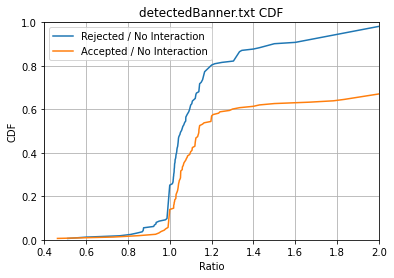

In [193]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

rejected_over_no_interaction = get_ratios('Reject', 'No interaction')
accepted_over_no_interaction = get_ratios('Accept', 'No interaction')

rejected_over_no_interaction_stats_df = get_cdf(rejected_over_no_interaction.values())
accepted_over_no_interaction_stats_df = get_cdf(accepted_over_no_interaction.values())

plt.plot(rejected_over_no_interaction_stats_df['value'], rejected_over_no_interaction_stats_df['cdf'], label='Rejected / No Interaction')
plt.plot(accepted_over_no_interaction_stats_df['value'], accepted_over_no_interaction_stats_df['cdf'], label='Accepted / No Interaction')

plt.axis([0.4, 2, 0, 1])

plt.title('detectedBanner.txt CDF')
plt.xlabel('Ratio')
plt.ylabel('CDF')

plt.legend(loc='upper left')

plt.grid(visible = True)

plt.savefig(FIG_DIR+'/CDF_rejected_accepted_over_no_interaction.png', dpi=600, facecolor='white')
plt.show()


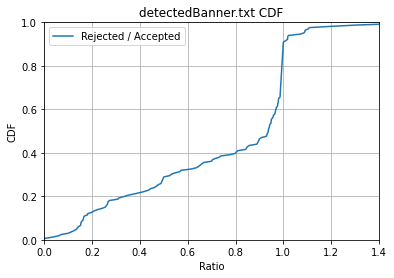

In [194]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

rejected_over_accepted = get_ratios('Reject', 'Accept')
rejected_over_accepted_stats_df = get_cdf(rejected_over_accepted.values())

plt.plot(rejected_over_accepted_stats_df['value'], rejected_over_accepted_stats_df['cdf'], label='Rejected / Accepted')

plt.axis([0, 1.4, 0, 1])

plt.title('detectedBanner.txt CDF')
plt.xlabel('Ratio')
plt.ylabel('CDF')

plt.legend(loc='upper left')

plt.grid(visible = True)

plt.savefig(FIG_DIR+'/CDF_rejected_over_accepted.png', dpi=600, facecolor='white')
plt.show()


### Sites with more rejected than accepted cookies

In [195]:
# more_rejected_than_accepted = {}
# for site_url, ratio in rejected_over_accepted.items():
#     if ratio > 1:
#         more_rejected_than_accepted[site_url] = ratio

# with open(CSV_DIR+'/more_rejected_than_accepted.csv', 'w') as csv_file:  
#     writer = csv.writer(csv_file)
#     writer.writerow(["site_url", "rejected/accepted"])
#     for key, value in more_rejected_than_accepted.items():
#        writer.writerow([key, value])

# more_rejected_than_no_interaction = {}
# for site_url, ratio in rejected_over_no_interaction.items():
#     if ratio > 1:
#         more_rejected_than_no_interaction[site_url] = ratio

# with open(CSV_DIR+'/more_rejected_than_no_interaction.csv', 'w') as csv_file:  
#     writer = csv.writer(csv_file)
#     writer.writerow(["site_url", "rejected/no_interaction"])
#     for key, value in more_rejected_than_no_interaction.items():
#        writer.writerow([key, value])

### Plots by Cookie Type

#### CDF Reject / No interaction

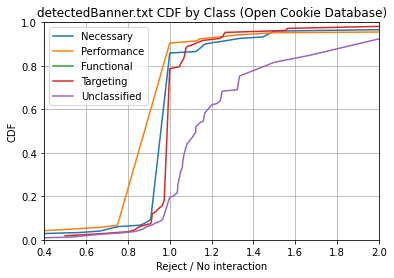

In [196]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

df_label_to_plot_label = {
    "count_necessary": "Necessary",
    "count_performance": "Performance",
    "count_functional": "Functional",
    "count_targeting": "Targeting",
    "count_unclassified": "Unclassified"
}

dfs = {}
for df_label, plot_label in df_label_to_plot_label.items():
    ratios = get_ratios('Reject', 'No interaction', lambda row: row[df_label])
    stats_df = get_cdf(ratios.values())
    dfs[plot_label] = stats_df

for plot_label, stats_df in dfs.items():
    plt.plot(stats_df['value'], stats_df['cdf'], label=plot_label)

plt.axis([0.4, 2, 0, 1])

plt.title('detectedBanner.txt CDF by Class (Open Cookie Database)')
plt.xlabel('Reject / No interaction')
plt.ylabel('CDF')

plt.legend(loc='upper left')

plt.grid(visible = True)

plt.savefig(FIG_DIR+'/CDF_class_reject_no_interaction.png', dpi=600, facecolor='white')
plt.show()

#### CDF Accept / No interaction

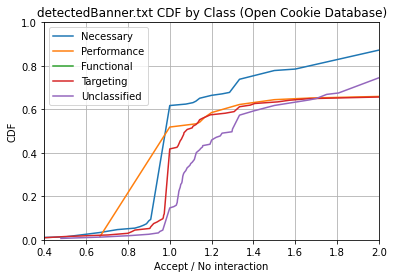

In [197]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

df_label_to_plot_label = {
    "count_necessary": "Necessary",
    "count_performance": "Performance",
    "count_functional": "Functional",
    "count_targeting": "Targeting",
    "count_unclassified": "Unclassified"
}

dfs = {}
for df_label, plot_label in df_label_to_plot_label.items():
    ratios = get_ratios('Accept', 'No interaction', lambda row: row[df_label])
    stats_df = get_cdf(ratios.values())
    dfs[plot_label] = stats_df

for plot_label, stats_df in dfs.items():
    plt.plot(stats_df['value'], stats_df['cdf'], label=plot_label)

plt.axis([0.4, 2, 0, 1])

plt.title('detectedBanner.txt CDF by Class (Open Cookie Database)')
plt.xlabel('Accept / No interaction')
plt.ylabel('CDF')

plt.legend(loc='upper left')

plt.grid(visible = True)

plt.savefig(FIG_DIR+'/CDF_class_accept_no_interaction.png', dpi=600, facecolor='white')
plt.show()

#### Boxplot Colorized by the 5 Cookie Types

Recreating Figure 4 from Helen's paper

In [210]:
# plot boxplot for distribution of 5 different cookie types (strictly necessary, performance, functional, targeting, unclassified) for three different modes of interactions.
def plot_boxplot_for_cookie_type(df):
    f, axes = plt.subplots(1, 5, figsize=(double_col_width, single_col_width))

    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#B42C63','#EC5B49']

    bp = sns.boxplot(x="clicked", y="count_necessary", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[0], orient="v")
    axes[0].set(ylabel="Number of cookies", xlabel="")
    axes[0].set(yscale="linear")
    axes[0].set(ylim=(0,10))
    axes[0].set_title("Necessary", y=1.05)
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    axes[0].set_xticklabels(labels=xtl,rotation=70)
    axes[0].tick_params(axis='y',which='both',left=True)

    bp = sns.boxplot(x="clicked", y="count_performance", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[1], orient="v")
    axes[1].set(ylabel="Number of cookies",xlabel="")
    axes[1].set(yscale="linear")
    axes[1].set(ylim=(0,10))
    axes[1].set_title("Performance", y=1.05)
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    axes[1].set_xticklabels(labels=xtl,rotation=70)
    axes[1].tick_params(axis='y',which='both',left=True)

    bp = sns.boxplot(x="clicked", y="count_functional", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[2], orient="v")
    axes[2].set(ylabel="Number of cookies",xlabel="")
    axes[2].set(yscale="linear")
    axes[2].set(ylim=(0,10))
    axes[2].set_title("Functional", y=1.05)
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    axes[2].set_xticklabels(labels=xtl,rotation=70)
    axes[2].tick_params(axis='y',which='both',left=True)

    bp = sns.boxplot(x="clicked", y="count_targeting", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[3], orient="v")
    axes[3].set(ylabel="Number of cookies",xlabel="")
    axes[3].set(yscale="linear")
    axes[3].set(ylim=(0,20))
    axes[3].set_title("Targeting", y=1.05) # FIXME: increase y axis limit to view
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    axes[3].set_xticklabels(labels=xtl,rotation=70)
    axes[3].tick_params(axis='y',which='both',left=True)

    bp = sns.boxplot(x="clicked", y="count_unclassified", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[4], orient="v")
    axes[4].set(ylabel="Number of cookies",xlabel="")
    axes[4].set(yscale="symlog")
    axes[4].set(ylim=(0,10**2))
    axes[4].set_title("Unclassified", y=1.05)
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
    axes[4].set_xticklabels(labels=xtl,rotation=70)
    axes[4].tick_params(axis='y',which='both',left=True)

    # plt.ylim( (0,10**2) )
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.figure(figsize=(20, 10)) # width, height (in inches)
    plt.rc('xtick', labelsize=8)

    f.suptitle('Distribution of Cookie Class for Different Modes of Interactions (Open Cookie Database)', y=1.1)
    # plt.show()

    f.savefig(FIG_DIR+'/boxplot_class.png', dpi=600, facecolor='white', bbox_inches='tight')
    # f.savefig(FIG_DIR+'/boxplot_class.pdf', bbox_inches='tight')


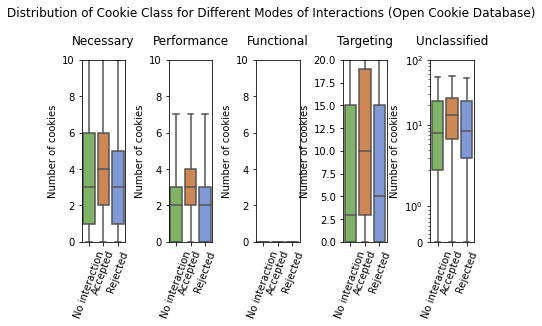

<Figure size 1440x720 with 0 Axes>

In [211]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

plot_boxplot_for_cookie_type(map_des_intersection['US East'])

In [200]:
EU_des = [map_des_finals[loc] for loc in EU_locs]
nonEU_des = [map_des_finals[loc] for loc in nonEU_locs]

KeyError: 'Germany'

In [ ]:
all_final_des = EU_des + nonEU_des

NameError: name 'EU_des' is not defined

### Desktop vs Mobile

#### Utility Functions

In [ ]:
def merge_des_mob(des, mob):
    return pd.merge(des, mob, on=["site_url","interaction"],how="inner", suffixes=["_d","_m"])

def add_diff_and_loc(df, first, second, loc):
    df["tr_des_mob_dif"] = df.apply(lambda x: x[first]-x[second], axis=1)
    df["loc"] = loc


In [ ]:
def get_complete_df_for_des_mob():
    pd_list = []
    for loc in locations:
        temp_des = groupby_url_and_interaction_mode(map_des_finals[loc])
        temp_mob = groupby_url_and_interaction_mode(map_mob_finals[loc])
        
        temp_merged = pd.merge(temp_des, temp_mob, on=["site_url","interaction"],how="inner", suffixes=["_d","_m"])
        temp_merged["tr_des_mob_dif"] = temp_merged.apply(lambda x: x["count_tr_d"]-x["count_tr_m"], axis=1)
        temp_merged["tp_des_mob_dif"] = temp_merged.apply(lambda x: x["count_tp_d"]-x["count_tp_m"], axis=1)
        temp_merged["loc"] = loc
        
        pd_list.append(temp_merged)
    
    return pd.concat(pd_list)

#### Initialization of DataFrames

In [ ]:
map_mob_finals = map_of_finals(run="mobile")

KeyError: 'mobile'

In [ ]:
merged_des_mob = get_complete_df_for_des_mob()

### Inner vs Landing Pages

#### Utility Functions

In [ ]:
#This function plots the percentage of differences for inner vs. landing page for each VP and for All together.
def print_inner_landing_dif_percentage(df):
    temp = df[df.interaction=="No interaction"]
    temp["more_landing_tp"] = temp['tp_in_land_dif'] < 0
    temp["more_inner_tp"] = temp['tp_in_land_dif'] > 0
    temp["more_landing_tr"] = temp['tr_in_land_dif'] < 0
    temp["more_inner_tr"] = temp['tr_in_land_dif'] > 0
    temp["eq_tp"] = temp['tp_in_land_dif'] == 0
    temp["eq_tr"] = temp['tr_in_land_dif'] == 0
    df_bools = temp[["domain", "more_landing_tp", "more_inner_tp", "more_landing_tr", "more_inner_tr", "eq_tp", "eq_tr", "loc"]]
    df_bools.reset_index(inplace=True, drop=True)
    grouped_domain_loc = df_bools.groupby(["domain", "loc"]).agg("all").reset_index()
    for loc in locations:
        temp_loc = grouped_domain_loc[grouped_domain_loc["loc"]==loc]
        print(f'location: {loc}')
        print(f"{'% of more TP in landing page:':<{37}} {temp_loc[temp_loc.more_landing_tp].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more TP in inner pages:':<{37}} {temp_loc[temp_loc.more_inner_tp].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more tracking in landing page:':<{37}} {temp_loc[temp_loc.more_landing_tr].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more tracking in inner pages:':<{37}} {temp_loc[temp_loc.more_inner_tr].shape[0]/temp_loc.shape[0]*100}")
    
    grouped_domain = grouped_domain_loc.groupby(["domain"]).agg("all").reset_index()
    print(f'\nlocation: All')
    print(f"{'% of more TP in landing page:':<{37}} {grouped_domain[grouped_domain.more_landing_tp].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more TP in inner pages:':<{37}} {grouped_domain[grouped_domain.more_inner_tp].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more tracking in landing page:':<{37}} {grouped_domain[grouped_domain.more_landing_tr].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more tracking in inner pages:':<{37}} {grouped_domain[grouped_domain.more_inner_tr].shape[0]/grouped_domain.shape[0]*100}")         

    
def is_inner(url):
    return url.count("/") > 2


def add_is_inner(df):
    df["is_inner"] = df.apply(lambda x: is_inner(x["site_url"]), axis=1)
    df["domain"] = df.apply(lambda x: get_domain(x["site_url"]), axis=1)


def get_df_with_landing_inner_diff(df):
    t1 = add_is_inner(df)
    t1 = df.groupby(["domain", "interaction","is_inner"]).agg("mean").reset_index()
    t2_i = t1[t1.is_inner]
    t2_l = t1[~t1.is_inner]
    t3 = pd.merge(t2_i, t2_l, on=["domain", "interaction"],how="left", suffixes=["_i","_l"])
    t3["tr_in_land_dif"] =  t3.apply(lambda x: x["count_tr_i"]-x["count_tr_l"], axis=1)
    t3["tp_in_land_dif"] =  t3.apply(lambda x: x["count_tp_i"]-x["count_tp_l"], axis=1)
    t3["fp_in_land_dif"] =  t3.apply(lambda x: x["count_fp_i"]-x["count_fp_l"], axis=1)
    return t3
        
    
def add_isinner_column(dfs):
    for df in dfs:
        add_is_inner(df)


def get_complete_df_for_landing_inner():
    pd_list = []
    for loc in map_inner_finals:
        temp = get_df_with_landing_inner_diff(map_inner_finals[loc]) 
        temp["loc"] = loc
        pd_list.append(temp)
    concat_temp = pd.concat(pd_list)
    concat_temp.reset_index(inplace=True) 
    return concat_temp


#### Initialization of DataFrames

In [ ]:
map_inner_finals = map_of_finals(run="innerpages")

### Impact of CCPA

#### Utility Functions

In [ ]:

# This function iterates DOM of all the websites and looks for DNSMPI phrases.
def dnsmpi_detection(html_df):
    with_dnsmpi = []

    dnsmpi_list = ["do not sell my personal information", 
    "do not sell my information", 
    "do not sell or share my personal information", 
    "do not sell or share my information"]
    
    dnsmpi_list_info = ["do not sell my info", 
    "do not sell my personal info", 
    "do not sell or share my info", 
    "do not sell or share my personal info"]
    domain_checked = []
    
    for i, x in html_df.iterrows():
        html = x.html.lower()
        soup = bs(html)
        substr_list = []
        domain = x.domain
        if domain in domain_checked:
            continue
        else:
            domain_checked.append(domain)
            for substr in dnsmpi_list:
                b = substr in html
                if b:
                    substr_list.append(substr)
                    dic_temp = {"domain": domain, "dnsmpi": substr_list, "html": html}
                    with_dnsmpi.append(dic_temp)
            if len(substr_list)==0:
                for substr in dnsmpi_list_info:
                    b = substr in html
                    if b:
                        substr_list.append(substr)
                        dic_temp = {"domain": domain, "dnsmpi": substr_list, "html": html}
                        with_dnsmpi.append(dic_temp)
    return with_dnsmpi



In [ ]:
def readlist(name):
    l = []
    file1= open(name, "r")
    while True:
        s = file1.readline()
        if not s:
            break
        s = s.strip('\n')
        l.append(s)
    return l

#### Initialization of DataFrames

In [ ]:
# load the domains for with DNSMPI and without DNSMPI in the lists
ran1k = readlist(INPUT_DIR+'/random39.txt')
ccp1k = readlist(INPUT_DIR+'/us_domain_dnsmpi39.txt')

ran10k = readlist(INPUT_DIR+'/random1373.txt')
ccp10k = readlist(INPUT_DIR+'/us_domain_dnsmpi1373.txt')

### Others

#### Distribution of banner detection time (Time To Wait)

In [ ]:
runs['desktop'].eu_north.visits[runs['desktop'].eu_north.visits.banners>0].ttw.value_counts()

0     375
10     31
Name: ttw, dtype: int64

In [ ]:
# Mobile and Desktop Dataframes polished for reachable crawls

# rd_m = runs['mobile'].polished
rd_d = runs['desktop'].polished

In [ ]:
def get_cmp(url, df=map_des_finals['US East']):
    site = df.loc[df['site_url'] == url]

    if site.empty:
        raise Exception('Site URL not found in the dataframe')

    print(site.cmp_name)
    print(site.nc_cmp_name)

get_cmp('https://bmj.com')

AttributeError: 'DataFrame' object has no attribute 'cmp_name'

In [ ]:
# this function plot the bar plot of total number of banners in each VP. It also shows the proportion of the CMPs.
def plot_banner_cmp_pro(df, name=""):
    num_reachble = df.shape[0]
    banners = df[['banners'+make_suffix(aws_name) for aws_name in AWS_names]]
    loc_ban = banners.astype(bool).sum()
    cmps = df[['nc_cmp_name'+make_suffix(aws_name) for aws_name in AWS_names]].fillna(False)
    loc_cmp = cmps.astype(bool).sum()
    cmp_banners = pd.DataFrame((cmps.astype(bool).values*banners.astype(bool).values), columns=[AWS_to_loc[c].capitalize() for c in AWS_names])
    loc_cmp_ban = cmp_banners.astype(bool).sum()
    Banners_Proportion = [x / num_reachble for x in loc_ban.values]
    CMP_Banners_Proportion = [x / num_reachble for x in loc_cmp_ban.values]
    Banners_Proportion_Stack = [a_i - b_i for a_i, b_i in zip(Banners_Proportion, CMP_Banners_Proportion)]
    # CMP_in_Banners = [(x / y) for x, y in zip(CMP_Banners_Proportion, Banners_Proportion)]
    df_temp = pd.DataFrame({'Vantage point':[AWS_to_loc[c] for c in AWS_names], 'non-CMP banners proportion':Banners_Proportion_Stack, 'CMP banners proportion':CMP_Banners_Proportion})
    df_temp.set_index('Vantage point', inplace=True)
    df_temp["Total"] = df_temp.sum(axis=1)
    df_temp.sort_values(by='Total', ascending=False, inplace=True)
    ax = df_temp.plot.bar(y=['non-CMP banners proportion','CMP banners proportion'], rot=25, stacked=True, figsize=(8, 6))
    ax.set_ylabel("Fraction of websites")
    ax.figure.show()
    ax.figure.savefig(FIG_DIR+'/banners_cmp_pro_'+name+'.pdf', bbox_inches='tight')
    ax.figure.savefig(FIG_DIR+'/banners_cmp_pro_'+name+'.png', bbox_inches='tight', facecolor='white', dpi=600)


df = rd_d[(rd_d.visit_id>=OFFSET_REJECT)]
ff = df.fillna(0).groupby("domain").any()
plot_banner_cmp_pro(ff)
wb_d = set(ff[ff.banners_us_east_1].index)



NameError: name 'rd_d' is not defined

In [ ]:
# This function plots the frequency of banners detected in 15 interations for each domain.
def occurrence_of_banner_in_iterations(run_name):
    Flag = False
    for aws in runs[run_name].AWS_list:
        dff = aws.visits
        dff['banners'] = dff['banners'].astype('bool')
        sizes = dff.groupby("domain").size()
        bans = dff.groupby("domain").sum().banners
        res = (bans / sizes * 15).astype(int).value_counts()
        res.rename(aws.name, inplace=True)
        if Flag == False:
            dft = res
            Flag = True
        else:
            dft = pd.concat([dft, res], axis=1)

    dft.fillna(0, inplace=True)
    dft.sort_index(inplace=True)
    return dft

banners_detected_by_domains = occurrence_of_banner_in_iterations("desktop")
banners_detected_by_domains.plot.line()

KeyError: 'desktop'

In [ ]:
top_x = 6
eu_v = runs['desktop'].us_east.visits
reject_v = eu_v[eu_v.visit_id>=OFFSET_REJECT]

cmpname = reject_v.cmp_name
cmpname_nc = reject_v.nc_cmp_name
cmp_freq = cmpname.value_counts()
cmp_freq_nc = cmpname_nc.value_counts()
ot_nc = reject_v[(reject_v.nc_cmp_name == 'onetrust') & (reject_v.cmp_name != 'OneTrust LLC')].shape[0]
didomi_nc = reject_v[(reject_v.nc_cmp_name == 'Didomi') & (reject_v.cmp_name != 'Didomi')].shape[0]
reject_v['other'] = (reject_v.nc_cmp_name.astype(bool) | reject_v.cmp_name.astype(bool)) & (reject_v.nc_cmp_name != 'Didomi') & (reject_v.nc_cmp_name != 'onetrust') & ~(reject_v.cmp_name.isin(cmp_freq[:top_x].index))
reject_v['merged'] = reject_v.cmp_name.str.cat(reject_v.nc_cmp_name,sep=" ")
others = reject_v['other'].astype(bool).sum()
cmp_freq_merged = cmp_freq.copy()
cmp_freq_merged["OneTrust LLC"] = cmp_freq["OneTrust LLC"] + ot_nc
# cmp_freq_merged["Didomi"] = cmp_freq["Didomi"] + didomi_nc


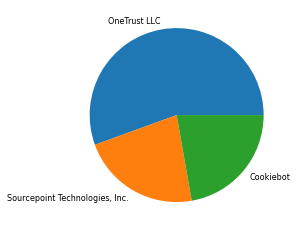

In [ ]:
# Market share of CMPs detected by __tcfapi()
tops = cmp_freq[:top_x]
tops.at['Others'] = cmp_freq[top_x:].sum()
tops.name = ""
ax = tops.plot.pie()
ax.yaxis.set_label_coords(0.4,0.5)
ax.figure.savefig(FIG_DIR + '/ms_total_1k.png', bbox_inches='tight', dpi=600, facecolor='white')

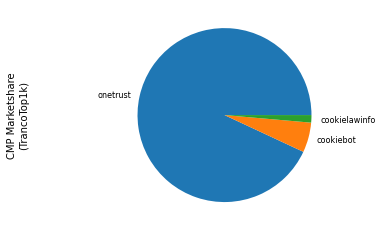

In [ ]:
# Market share of CMPs detected by NeverConsent addon
tops = cmp_freq_nc[:top_x]
tops.at['Others'] = cmp_freq_nc[top_x:].sum()
tops.name = "CMP Marketshare\n(TrancoTop1k)"
ax = tops.plot.pie()
ax.yaxis.set_label_coords(-0.4,0.5)
# ax.figure.show()
# ax.figure.savefig('./ms_total_1k.png', bbox_inches='tight')

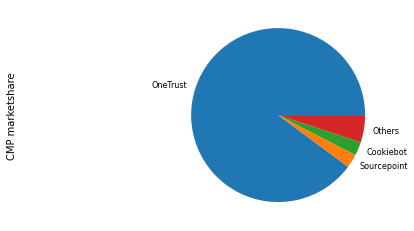

In [ ]:
# Market share of CMPs detected by union of __tcfapi() and NeverConsent addon
tops = cmp_freq_merged[:top_x]
tops.at['Others'] = others
tops.name = "CMP marketshare"
tops.index = [x.split()[0] for x in tops.index]
ax = tops.plot.pie()
ax.yaxis.set_label_coords(-0.7,0.5)
# ax.figure.show()
ax.figure.savefig(FIG_DIR+'/CMP_share.png', bbox_inches='tight', dpi=600, facecolor='white')

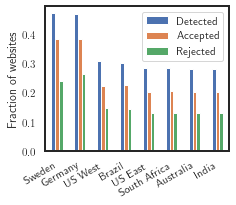

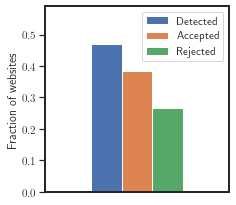

In [ ]:
# Barplot for banner detected in different location
def plot_btn_pro(df, name="", AWSs=AWS_names):
    num_reachble = df[df.visit_id<OFFSET_ACCEPT].shape[0]
        
    banners = df[df.visit_id<OFFSET_ACCEPT][['banners'+make_suffix(aws_name) for aws_name in AWSs]]
    loc_ban = banners.astype(bool).sum()
    Banners_Proportion = [x / num_reachble for x in loc_ban.values]

    num_reachble = df[(df.visit_id>=OFFSET_ACCEPT)&(df.visit_id<OFFSET_REJECT)].shape[0]
    btn_status = df[(df.visit_id>=OFFSET_ACCEPT)&(df.visit_id<OFFSET_REJECT)][['btn_status'+make_suffix(aws_name) for aws_name in AWSs]]
    loc_btn_ban = btn_status.fillna(0).astype(bool).sum()
    Btn_Status_Proportion = [x / num_reachble for x in loc_btn_ban.values]

    num_reachble = df[(df.visit_id>=OFFSET_REJECT)].shape[0]
    btn_status_r = df[(df.visit_id>=OFFSET_REJECT)][['btn_status'+make_suffix(aws_name) for aws_name in AWSs]]
    btn_set_status = df[(df.visit_id>=OFFSET_REJECT)][['btn_set_status'+make_suffix(aws_name) for aws_name in AWSs]]
    loc_btn_ban_r = btn_status_r.fillna(0).astype(bool).sum()
    loc_btn_set_ban = btn_set_status.applymap(lambda x: x==1).sum()
    Btn_Status_R_Proportion = [(x + y) / num_reachble for x, y in zip(loc_btn_ban_r.values, loc_btn_set_ban.values)]

    df = pd.DataFrame({'Vantage point':[AWS_to_loc[c] for c in AWSs], 'Detected':Banners_Proportion, 'Accepted':Btn_Status_Proportion, 'Rejected':Btn_Status_R_Proportion})
    df.sort_values('Detected', inplace=True, ascending=False)
        
    ax = df.plot.bar(x='Vantage point', y=['Detected','Accepted','Rejected'], rot=0, stacked=False, figsize=(single_col_width, single_col_width-.42))
    if len(AWSs)==1:
        ax.set_ylim(0, .59)
        ax.tick_params(bottom=False, top=False, left=True, right=False)
        ax.get_xaxis().set_ticks([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
        dx = 7 / 72.
        dy = 6 / 72.

    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("Fraction of websites")
    ax.figure.show()
    ax.figure.savefig(FIG_DIR+'/banners_btn_pro_'+name+'.pdf', bbox_inches='tight')

plot_btn_pro(rd_d, name="10kd")

plot_btn_pro(rd_d, name="germany", AWSs=["eu-central-1"])
accept_d = df[(df.visit_id>=OFFSET_ACCEPT)&(df.visit_id<OFFSET_REJECT)&(df.btn_status_eu_central_1.fillna(0).astype(bool))]


In [ ]:
# boxplot, comparering EU and nonEU coutries w.r.t tracking cookie dist for different mode of interactions.
temp_intersection_merged = pd.merge(map_des_intersection["Sweden"], map_des_intersection["India"], on=["site_url","clicked"],how="inner", suffixes=["_s","_i"])
temp_intersection_merged.rename(columns = {'count_tr_s':'Sweden', 'count_tr_i':'India'}, inplace = True)
dd=pd.melt(temp_intersection_merged,id_vars=['clicked'],value_vars=['Sweden','India'],var_name='Vantage Point', value_name="Tracking Cookies")
sns.boxplot(x='clicked',y='Tracking Cookies',data=dd,hue='Vantage Point')

KeyError: 'Sweden'

## 3. Data Collection and Approach

#### Section 3.1 details

In [ ]:
calc_max_min_time_def_for_all_vps()

,site_url,site_rank,dtg_eu-central-1,dtg_eu-north-1,dtg_us-east-1,dtg_us-west-1,dtg_ap-south-1,dtg_sa-east-1,dtg_af-south-1,dtg_ap-southeast-2,max,min,max_i,min_i,def
0,https://google.com,0,2022-03-08 21:03:15,2022-03-08 21:02:52,2022-03-08 21:03:19,2022-03-08 21:02:51,2022-03-08 21:03:18,2022-03-08 21:02:54,2022-03-08 21:02:54,2022-03-08 21:02:57,2022-03-08 21:03:19,2022-03-08 21:02:51,1646773399000000000,1646773371000000000,28.0
1,https://google.com,10000000,2022-03-08 21:03:15,2022-03-08 21:02:52,2022-03-08 21:03:19,2022-03-08 21:02:51,2022-03-08 21:03:18,2022-03-08 21:02:54,2022-03-08 21:02:54,2022-03-08 21:02:57,2022-03-08 21:03:19,2022-03-08 21:02:51,1646773399000000000,1646773371000000000,28.0
2,https://google.com,20000000,2022-03-08 21:03:15,2022-03-08 21:02:52,2022-03-08 21:03:19,2022-03-08 21:02:51,2022-03-08 21:03:18,2022-03-08 21:02:54,2022-03-08 21:02:54,2022-03-08 21:02:57,2022-03-08 21:03:19,2022-03-08 21:02:51,1646773399000000000,1646773371000000000,28.0
3,https://google.com,1,2022-03-08 21:03:15,2022-03-08 21:02:52,2022-03-08 21:03:19,2022-03-08 21:02:51,2022-03-08 21:03:18,2022-03-08 21:02:54,2022-03-08 21:02:54,2022-03-08 21:02:57,2022-03-08 21:03:19,2022-03-08 21:02:51,1646773399000000000,1646773371000000000,28.0
4,https://google.com,20000001,2022-03-08 21:03:15,2022-03-08 21:02:52,2022-03-08 21:03:19,2022-03-08 21:02:51,2022-03-08 21:03:18,2022-03-08 21:02:54,2022-03-08 21:02:54,2022-03-08 21:02:57,2022-03-08 21:03:19,2022-03-08 21:02:51,1646773399000000000,1646773371000000000,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37600,https://valueimpression.com/privacy.html,10012533,2022-03-12 13:59:36,2022-03-12 14:21:22,2022-03-12 18:12:29,2022-03-12 14:52:05,2022-03-12 16:37:27,2022-03-12 16:33:22,2022-03-12 16:33:18,2022-03-12 17:38:05,2022-03-12 18:12:29,2022-03-12 13:59:36,1647108749000000000,1647093576000000000,15173.0
37601,https://valueimpression.com/privacy.html,20012533,2022-03-12 13:59:39,2022-03-12 14:21:27,2022-03-12 18:12:34,2022-03-12 14:52:12,2022-03-12 16:37:32,2022-03-12 16:33:37,2022-03-12 16:33:21,2022-03-12 17:38:06,2022-03-12 18:12:34,2022-03-12 13:59:39,1647108754000000000,1647093579000000000,15175.0
37602,https://valueimpression.com/privacy.html,12534,2022-03-12 13:59:48,2022-03-12 14:21:35,2022-03-12 18:12:51,2022-03-12 14:52:16,2022-03-12 16:37:33,2022-03-12 16:33:42,2022-03-12 16:33:36,2022-03-12 17:38:14,2022-03-12 18:12:51,2022-03-12 13:59:48,1647108771000000000,1647093588000000000,15183.0
37603,https://valueimpression.com/privacy.html,10012534,2022-03-12 13:59:50,2022-03-12 14:21:36,2022-03-12 18:12:57,2022-03-12 14:52:23,2022-03-12 16:37:39,2022-03-12 16:33:44,2022-03-12 16:33:47,2022-03-12 17:38:16,2022-03-12 18:12:57,2022-03-12 13:59:50,1647108777000000000,1647093590000000000,15187.0


#### Section 3.3 details

In [ ]:
# This fumction is to fetch the javascript_cookies table to get the most frequent trackers.
def get_js_cookies(run='desktop', location="Sweden"):
    AWS_obj = get_AWS_obj(run, location)
    javascript_cookies = AWS_obj.javascript_cookies
    incomplete_visits = AWS_obj.incomplete_visits
    site_visits  = AWS_obj.site_visits
    visits = AWS_obj.visits
    
    incomplete_visits.drop_duplicates(inplace=True)
    incomplete_visits["complete"] = False
    javascript_cookies = javascript_cookies.sort_values(by=["visit_id", "event_ordinal"]).drop_duplicates(subset=["visit_id", "host", "name"], keep="last")
    javascript_cookies = javascript_cookies[javascript_cookies["record_type"] == "added-or-changed"]
    site_visits = pd.merge(site_visits, incomplete_visits, on="visit_id", how="left").fillna("True")
    site_visits = site_visits.astype({"complete": bool})
    
    site_visits = pd.merge(site_visits, visits, left_on="site_rank", right_on="visit_id", how="left", suffixes=("", "_dropme")).drop(columns="visit_id_dropme").fillna(0)
    
    site_visits["accept_clicked"] = site_visits.apply(lambda x: abs(x["btn_status"]) == 1, axis=1)
    site_visits["reject_clicked"] = site_visits.apply(lambda x: abs(x["btn_status"]) == 2 or x["btn_set_status"] == 1, axis=1)
    
    site_visits.drop_duplicates(subset=["site_url"], keep="last",inplace=True)

    site_visits_cookies = pd.merge(site_visits, javascript_cookies, on="visit_id")
    site_visits_cookies["is_first_party"] = site_visits_cookies.apply(lambda x: is_first_party(x["site_url"], x["host"], psl), axis=1)
    
    tracking_list = get_tracking_list(tracking_lists)
    site_visits_cookies["is_tracking"] = site_visits_cookies.apply(lambda x: is_tracking(x["site_url"], x["host"], psl, tracking_list), axis=1)
    site_visits_cookies["reject"] = site_visits_cookies["site_rank"] >= OFFSET_REJECT
    site_visits_cookies["accept"] = (site_visits_cookies["site_rank"] < OFFSET_REJECT) & (site_visits_cookies["site_rank"] >= OFFSET_ACCEPT)
    site_visits_cookies["interaction"] = site_visits_cookies.apply(lambda x: get_interaction_mode(x["accept"], x["reject"]), axis=1)
    return site_visits_cookies

# This function shows the top trackers for the top websites with most tracking cookies.
def show_top_trackers_in_domains_with_most_tracking(top_domains=50, top_trackers=50, loc="Germany"):
    df_js = get_js_cookies(run='desktop', location=loc)
    des_grouped = groupby_url_and_interaction_mode(map_des_finals[loc])
    top_tracking_domains = list(des_grouped[des_grouped.interaction=="No interaction"].sort_values(ascending=False, by="count_tr").head(top_domains).site_url)
    df_top_domains_js_temp = df_js[df_js.site_url.isin(top_tracking_domains)]
    df_top_domains_js_temp["host"] = df_top_domains_js_temp.apply(lambda x: psl.get_public_suffix(x["host"]), axis=1)
    df_top_domains_js = df_top_domains_js_temp.drop_duplicates(subset=["visit_id", "host"], keep="last")
    return df_top_domains_js.host.value_counts().head(top_trackers)


In [ ]:
show_top_trackers_in_domains_with_most_tracking()

bidswitch.net            50
yahoo.com                49
adnxs.com                49
doubleclick.net          49
pubmatic.com             48
adsrvr.org               48
mathtag.com              48
adform.net               48
turn.com                 46
everesttech.net          45
casalemedia.com          45
adition.com              45
w55c.net                 45
onaudience.com           44
simpli.fi                44
quantserve.com           44
stackadapt.com           43
bidr.io                  43
zeotap.com               41
taboola.com              41
audrte.com               41
de17a.com                41
ipredictive.com          40
semasio.net              40
loopme.me                40
technoratimedia.com      38
bidtheatre.com           37
tribalfusion.com         36
fiftyt.com               36
erne.co                  35
playground.xyz           35
rubiconproject.com       34
weborama.fr              34
360yield.com             33
bnmla.com                32
contextweb.com      

#### Section 3.4 details

In [ ]:
show_detection_status("desktop")

eu-central-1   detect 64239 and 15434 websites with banners and CMP respectively out of 149545 entries in DB.
eu-north-1     detect 64560 and 15537 websites with banners and CMP respectively out of 149622 entries in DB.
us-east-1      detect 38982 and 11199 websites with banners and CMP respectively out of 149831 entries in DB.
us-west-1      detect 42347 and 11395 websites with banners and CMP respectively out of 149864 entries in DB.
ap-south-1     detect 38471 and 10862 websites with banners and CMP respectively out of 149921 entries in DB.
sa-east-1      detect 41390 and 11250 websites with banners and CMP respectively out of 149916 entries in DB.
af-south-1     detect 38859 and 10983 websites with banners and CMP respectively out of 149889 entries in DB.
ap-southeast-2 detect 38568 and 11016 websites with banners and CMP respectively out of 149876 entries in DB.


In [ ]:
show_run_status("desktop")

eu-central-1   reachable: 138018, selenium timeout: 946, unreachable: 10175, exception during banner detection 406.
eu-north-1     reachable: 138112, selenium timeout: 939, unreachable: 10164, exception during banner detection 407.
us-east-1      reachable: 138490, selenium timeout: 930, unreachable: 10028, exception during banner detection 383.
us-west-1      reachable: 138435, selenium timeout: 890, unreachable: 10127, exception during banner detection 412.
ap-south-1     reachable: 138345, selenium timeout: 961, unreachable: 10203, exception during banner detection 412.
sa-east-1      reachable: 137925, selenium timeout: 1125, unreachable: 10415, exception during banner detection 451.
af-south-1     reachable: 137381, selenium timeout: 1528, unreachable: 10417, exception during banner detection 563.
ap-southeast-2 reachable: 138325, selenium timeout: 891, unreachable: 10240, exception during banner detection 420.


## 4. Effect of Cookie Banners

In [ ]:
# this fuction plots the boxplot for distribution of different cookies (FP, TP and tracking) for three differen mode of interactions.
def plot_boxplot_for_cookie_dist(df):
    f, axes = plt.subplots(1, 3, figsize=(double_col_width, single_col_width))
    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#B42C63','#EC5B49']

    bp =sns.boxplot(x="clicked", y="count_fp", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[0], orient="v")
    axes[0].set(ylabel="Average number of cookies", xlabel="")
    axes[0].set(yscale="symlog")
    axes[0].set(ylim=(0,10**2))
    axes[0].set(title="First Party")
    # axes[0].set(xticklabels(rotation=30, ha="right"))
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
    axes[0].set_xticklabels(labels=xtl,rotation=20, )
    axes[0].tick_params(axis='y',which='both',left=True)


    bp =sns.boxplot(x="clicked", y="count_tp", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[1], orient="v")
    axes[1].set(ylabel="",xlabel="")
    axes[1].set(yscale="symlog")
    axes[1].set(ylim=(0,10**2))
    axes[1].set(title="Third Party")
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
    axes[1].set_xticklabels(labels=xtl,rotation=20)
    axes[1].tick_params(axis='y',which='both',left=True)


    bp =sns.boxplot(x="clicked", y="count_tr", data=df, palette=colors, showfliers=False, saturation=0.65, ax = axes[2], orient="v")
    axes[2].set(ylabel="",xlabel="")
    axes[2].set(yscale="symlog")
    axes[2].set(ylim=(0,10**2))
    axes[2].set(title="Tracking")
    xtl = axes[0].get_xticklabels()
    yaxis = bp.yaxis
    yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
    axes[2].set_xticklabels(labels=xtl,rotation=20)
    axes[2].tick_params(axis='y',which='both',left=True)

    plt.ylim( (0,10**2) )

    # f.savefig(FIG_DIR+'/boxplot_type.pdf', bbox_inches='tight')
    plt.savefig(FIG_DIR+'/boxplot_type.png', dpi=600, facecolor='white', bbox_inches='tight')
    


#### Fig. 2

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline
plot_boxplot_for_cookie_dist(map_des_intersection["US East"])

NameError: name 'plot_boxplot_for_cookie_dist' is not defined

In [ ]:
def top_cmp(run):
        top_cmps = pd.DataFrame()
        for cmp in cmp_freq.index[:6]:
            cmp_name = cmp.split()[0].lower()
            cmp_sorted = reject_v.groupby('domain').first().set_index('visit_id').cmp_name.sort_index()
            cmp_bool_series = cmp_sorted.map(lambda x: 1 if type(x)==str and cmp_name in x.lower() else 0)
            temp_df = cmp_bool_series.cumsum()
            temp_df.index -= OFFSET_REJECT
            temp_df.index /= 5
            temp_df = temp_df/(temp_df.index) * 100
            top_cmps[cmp.split()[0]] = temp_df
        temp_df = reject_v.groupby('domain').first().set_index('visit_id').other.sort_index()
        temp_df.index -= OFFSET_REJECT
        temp_df.index /= 5
        temp_df = temp_df.cumsum()
        temp_df = temp_df/(temp_df.index) * 100
        top_cmps["Others"] = temp_df
        return top_cmps
            
def plot_dist_ranked_top10k(run='desktop'):
    tops = [10, 50, 100, 250, 500, 1000, 2000, 3000, 5000, 7500, 10000]
    l = len(tops)
    a = np.arange(l)
    temp_df = top_cmp(run)
    ax = temp_df.plot.area(figsize=(double_col_width, single_col_width-0.42), linewidth = 0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.legend(ncol=2, loc='center left',  bbox_to_anchor=(0.53, 0.77))
    ax.set(xlabel="Toplist rank", ylabel="Cumulative market share")
    ax.set_xlim(0, 10000)
    ax.set_ylim(0, 22)
    xlabels = [0 if x==0 else '{:,.0f}'.format(x) + 'k' for x in ax.get_xticks()/1000]
    ax.tick_params(bottom=True, top=False, left=True, right=False)
    ax.set_xticklabels(xlabels)
    ax.figure.savefig(FIG_DIR+'/cumulative_ms_10k.pdf', bbox_inches='tight')

    

#### Fig. 3

In [ ]:
plot_dist_ranked_top10k()

NameError: name 'cmp_freq' is not defined

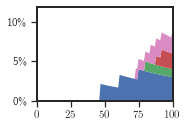

In [ ]:
def plot_dist_ranked_top100(run='desktop'):
    temp_df = top_cmp('desktop')
    ax = temp_df.plot.area(legend=False, figsize=(single_col_width*.8, single_col_width*.55), linewidth = 0)
    ax.xaxis.label.set_visible(False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 12)
    ax.tick_params(bottom=True, top=False, left=True, right=False)
    ax.figure.savefig(FIG_DIR+'/cumulative_ms_100.png', bbox_inches='tight')
    
plot_dist_ranked_top100()

## 5. Impact of Geographical Location

In [ ]:
# for keeping track of rejected but not accepted cases
r_na = None

# this method is used for printing number of rejection and acceptance and diefference of them for a given 
def method_name(accept_offset, reject_offset, btn_status, btn_status_r):
    global r_na
    rej_vps = btn_status_r.fillna(0).astype(bool)
    rej = rej_vps.any(axis=1)
    rej_domains = set(reject_offset[rej].domain.unique())
    acc_vps = btn_status.fillna(0).astype(bool)
    acc = acc_vps.any(axis=1)
    acc_domains = set(accept_offset[acc].domain.unique())
    # print(len(acc_domains))
    # print(len(rej_domains.intersection(acc_domains)))
    # print(len(rej_domains.difference(acc_domains)))
    r_na = rej_domains.difference(acc_domains)


def plot_btn_pro(df, name="", AWSs=AWS_names):
    num_reachble = df[df.visit_id < OFFSET_ACCEPT].shape[0]

    banners = df[df.visit_id < OFFSET_ACCEPT][['banners' + make_suffix(aws_name) for aws_name in AWSs]]
    loc_ban = banners.astype(bool).sum()
    Banners_Proportion = [x / num_reachble for x in loc_ban.values]

    accept_offset = df[(df.visit_id >= OFFSET_ACCEPT) & (df.visit_id < OFFSET_REJECT)]
    num_reachble = accept_offset.shape[0]
    btn_status = accept_offset[['btn_status' + make_suffix(aws_name) for aws_name in AWSs]]
    loc_btn_ban = btn_status.fillna(0).astype(bool).sum()
    Btn_Status_Proportion = [x / num_reachble for x in loc_btn_ban.values]
    reject_offset = df[(df.visit_id >= OFFSET_REJECT)]
    num_reachble = reject_offset.shape[0]
    btn_status_r = reject_offset[['btn_status' + make_suffix(aws_name) for aws_name in AWSs]]
    btn_set_status = reject_offset[['btn_set_status' + make_suffix(aws_name) for aws_name in AWSs]]
    loc_btn_ban_r = btn_status_r.fillna(0).astype(bool).sum()
    loc_btn_set_ban = btn_set_status.applymap(lambda x: x == 1).sum()
    Btn_Status_R_Proportion = [(x + y) / num_reachble for x, y in zip(loc_btn_ban_r.values, loc_btn_set_ban.values)]
    method_name(accept_offset, reject_offset, btn_status, btn_status_r)
    Banners_Proportion_Stack = [a_i - b_i for a_i, b_i in zip(Banners_Proportion, Btn_Status_Proportion)]
    Btn_Status_Proportion_Stack = [a_i - b_i for a_i, b_i in zip(Btn_Status_Proportion, Btn_Status_R_Proportion)]
    df = pd.DataFrame(
        {'Vantage point': [AWS_to_loc[c] for c in AWSs], 'Det. $\cap$ Acc. $\cap$ Rej.': Btn_Status_R_Proportion,
         'Det. $\cap$ Acc.': Btn_Status_Proportion_Stack, 'Det.': Banners_Proportion_Stack,
         'Banners': Banners_Proportion})
    df.sort_values('Banners', inplace=True, ascending=False)
    if len(AWSs) > 1:
        rotate_deg = 35
    else:
        rotate_deg = 0
    # colors = ["#006D2C", "#74C476","#EFEFEF"]
    ax = df.plot.bar(x='Vantage point', y=['Det. $\cap$ Acc. $\cap$ Rej.', 'Det. $\cap$ Acc.', 'Det.'], rot=rotate_deg,
                     stacked=True, figsize=(single_col_width, single_col_width))
    # print(df)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    v = list(by_label.values())
    v.reverse()
    k = list(by_label.keys())
    k.reverse()
    ax.legend(v, k)
    ax.set_ylabel("Fraction of websites")
    ax.tick_params(bottom=True, top=False, left=True, right=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_deg, ha="right")

    # move the position of xticks
    dx = 7 / 72.
    dy = 2 / 72.
    # offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    #
    # # apply offset transform to all x ticklabels.
    # for label in ax.xaxis.get_majorticklabels():
    #     label.set_transform(label.get_transform() + offset)
    ax.xaxis.label.set_visible(False)
    ax.figure.show()
    ax.figure.savefig(FIG_DIR+'/banners_btn_pro_' + name + '.pdf', bbox_inches='tight')



#### Fig. 4

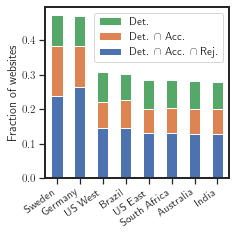

In [ ]:
plot_btn_pro(rd_d)

In [ ]:
def plot_cookies_dif_EU_nonEU():
    EU_nonEU_concat = get_EU_nonEU_acc_no()
    f, axes = plt.subplots(1, 2, figsize=(double_col_width, single_col_width))

    #f.set_size_inches(single_col_width, single_col_width)
    plt.subplots_adjust(hspace=0.9, wspace=0.3)

    colors = ['#e69500', '#6890F0', '#6890F0']
    bp = sns.ecdfplot(data=EU_nonEU_concat, x="count_tp", hue="mode", hue_order=['No interaction non-EU', 'No interaction EU', 'Accept EU'], linewidth=2, palette=colors, ax = axes[0])
    axes[0].set(xlabel="Third Party")
    # axes[0].set(ylim=(0, 1.02), xlabel ='Difference in Tracking cookies: Desktop vs. Mobile', ylabel = "Fraction of websites")
    axes[0].set(xscale="log")
    axes[0].legend_.set_title(None)
    axes[0].set(title="Third Party")
    axes[0].set(ylabel= "Fraction of websites",xlabel="Avg. number of cookies")
    axes[0].lines[0].set_linestyle("--")
    axes[0].legend(['Accept EU','No interaction EU', 'No interaction non-EU'])
    axes[0].tick_params(axis='x',which='both',bottom=True)
    bp.set(ylim=(0, 1.02))
    # bp.set(xlim=(0, 300))
    bp.grid()

    bp = sns.ecdfplot(data=EU_nonEU_concat, x="count_tr", hue="mode", hue_order=['No interaction non-EU', 'No interaction EU', 'Accept EU'], linewidth=2, palette=colors, ax = axes[1])
    # axes[1].set(ylabel="Average number of first party cookies", xlabel="")
    # axes[1].set(ylim=(0, 1.02), xlabel ='Difference in Tracking cookies: Desktop vs. Mobile', ylabel = "Fraction of websites")
    axes[1].set(xscale="log")
    axes[1].legend_.set_title(None)
    axes[1].set(title="Tracking")
    axes[1].set(ylabel= "",xlabel="Avg. number of cookies")
    axes[1].lines[0].set_linestyle("--")
    axes[1].legend(['Accept EU','No interaction EU', 'No interaction non-EU'])
    axes[1].tick_params(axis='x',which='both',bottom=True)
    plt.ylabel(r' ')
    bp.set(ylim=(0, 1.02))
    # bp.set(xlim=(0, 300))
    plt.grid()
    f.suptitle("", fontsize=16, y=-0.05, verticalalignment='bottom')
    f.savefig(FIG_DIR+'/eu_vs_noneu.pdf', bbox_inches='tight')

#### Fig. 5

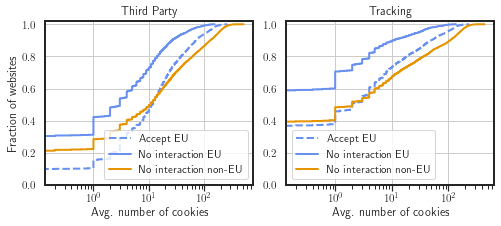

In [ ]:
plot_cookies_dif_EU_nonEU()

## 6. Website Cookie Consistency

In [ ]:
def get_tranco_rank_consistency(site_rank, offset=1):

    # Reject
    if site_rank >= OFFSET_REJECT:
        site_rank -= OFFSET_REJECT
        
    # Accept
    elif site_rank >= OFFSET_ACCEPT:
        site_rank -= OFFSET_ACCEPT
        
    # No interaction
    else:
        pass

    return offset+int(site_rank/100)


In [ ]:
map_consist_finals = map_of_finals(run="consistency")

In [ ]:
def get_consist_merge():
    df_cons = None

    for loc in locations:
        temp = map_consist_finals[loc]
        temp["site_url"] = temp["site_url"].apply(lambda x: x.strip())
        temp["location"] = loc

        if df_cons is None:
            df_cons = temp
        else:
            df_cons = df_cons.append(temp)
    
    df_cons["reject"] = df_cons["site_rank"] >= OFFSET_REJECT
    df_cons["accept"] = (df_cons["site_rank"] < OFFSET_REJECT) & (df_cons["site_rank"] >= OFFSET_ACCEPT)
    df_cons_complete = df_cons[df_cons["complete"]]    
    df_cons_complete["count_fp"] = df_cons_complete.count_fp.astype(int)
    df_cons_complete["count_tp"] = df_cons_complete.count_tp.astype(int)
    return df_cons_complete


In [ ]:
def get_df_for_inter_loc_consist():
    alpha = 0.05
    cons_common_tuples_mw_tp = None
    df_temp = get_consist_merge()

    for accept, reject in [(False, False), (True, False), (False, True)]:
        for w in df_temp["site_url"].unique():
            ss = df_temp[(df_temp["accept"] == accept) & (df_temp["reject"] == reject) & (df_temp["site_url"] == w)]
            temp = sp.posthoc_mannwhitney(df_temp[(df_temp["accept"] == accept) & (df_temp["reject"] == reject) & (df_temp["site_url"] == w)], val_col="count_tp", group_col="location", p_adjust="holm")

            # Select significant results as '1', others are set to '0'
            temp = temp.apply(lambda x: [1 if y < alpha else 0 for y in x])

            # Skip locations where we do not have responses from all countries
            if len(temp.index) != len(locations) or len(temp.columns) != len(locations):
                print("Skipped ", w, accept, reject, " due to ", len(temp.columns), " instead of ", len(locations), " locations")
                continue
            if cons_common_tuples_mw_tp is None:
                    cons_common_tuples_mw_tp = temp
            else:
                cons_common_tuples_mw_tp += temp

    cons_common_tuples_mw_tp_str = dict()

    for loc1 in locations:
        for loc2 in locations:
            if loc1 >= loc2:
                continue

            cons_common_tuples_mw_tp_str[loc1 + " vs. " + loc2] = cons_common_tuples_mw_tp.loc[loc1,loc2]
    
    return cons_common_tuples_mw_tp_str


In [ ]:
cons_common_tuples_mw_tp_str = get_df_for_inter_loc_consist()

Skipped  https://gujarat.gov.in False False  due to  6  instead of  8  locations
Skipped  https://gujarat.gov.in True False  due to  7  instead of  8  locations
Skipped  https://gujarat.gov.in False True  due to  6  instead of  8  locations


In [ ]:
def plot_heatmap():
    df_temp = get_consist_merge()
    df = pd.DataFrame(columns=['s','d'])
    vps = set()
    keys = cons_common_tuples_mw_tp_str.keys()
    maxi = 0
    for x in keys:
        v = cons_common_tuples_mw_tp_str[x]
        if v>maxi:
            maxi = v
    keys = cons_common_tuples_mw_tp_str.keys()
    denom = 900
    for x in keys:
        s, d = x.split('vs.')
        s, d = [vp.strip() for vp in x.split('vs.')]
        vps.add(s)
        vps.add(d)
        v = cons_common_tuples_mw_tp_str[x]
        df = pd.concat([df, pd.DataFrame.from_records([{'s' : s, 'd' : d, 'v' : v/denom}])], ignore_index=True)
        df = pd.concat([df, pd.DataFrame.from_records([{'s' : d, 'd' : s, 'v' : v/denom}])], ignore_index=True)

    df = df.pivot("s", "d", "v")
    df = df.fillna(0)
    new_clm_order = ["Germany", "Sweden", "Australia", "Brazil", "India", "US East", "US West", "South Africa"]
    df = df[new_clm_order]
    df = df.reindex(new_clm_order)

    f, axes = plt.subplots(1, 2, figsize=(double_col_width, single_col_width))

    for loc in locations:
        bp = sns.ecdfplot(df_temp[df_temp["location"] == loc].groupby(["site_url", "accept", "reject"])["count_tp"].agg(list).apply(lambda x: scipy.stats.variation(x)).fillna(0), label=loc, ax = axes[0])

    axes[0].legend(ncol=2)
    axes[0].set(xscale="log")
    axes[0].set(xlabel="Coefficient of variation of TP cookies")
    axes[0].set(ylabel="Fraction of website-interaction tuples")
    bp.set(ylim=(0, 1.05))

    axes[0].set_title('(a)', y=-0.45)


    bp = sns.heatmap(df, cmap="coolwarm", ax = axes[1]) 

    labels = axes[1].get_xticklabels()
    for label in labels:
        label.set_text(label.get_text().replace("Germany", r"\textbf{Germany}"))
        label.set_text(label.get_text().replace("Sweden", r"\textbf{Sweden}"))
    axes[1].set_xticklabels(labels)

    labels = axes[1].get_yticklabels()
    for label in labels:
        label.set_text(label.get_text().replace("Germany", r"\textbf{Germany}"))
        label.set_text(label.get_text().replace("Sweden", r"\textbf{Sweden}"))
    axes[1].set_yticklabels(labels)

    axes[1].set(xlabel=None)
    axes[1].set(ylabel=None)
    axes[1].set_title('(b)', y=-0.45)
    f.suptitle("", fontsize=16, y=-0.05, verticalalignment='bottom')
    f.savefig(FIG_DIR+"/thread_heatmap.pdf", bbox_inches='tight')

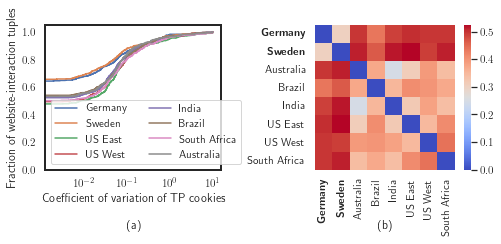

In [ ]:
plot_heatmap()

## 7. Landing vs. Inner pages

In [ ]:
merged_landing_inner = get_complete_df_for_landing_inner()

In [ ]:
#This function plot landing vs. inner pages differences.
def plot_landing_inner_dif():
    f, axes = plt.subplots(1, 2, figsize=(double_col_width, single_col_width))

    #f.set_size_inches(single_col_width, single_col_width)
    plt.subplots_adjust(hspace=0.9, wspace=0.3)

    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#B42C63','#EC5B49']
    bp = sns.ecdfplot(x="tp_in_land_dif", data=merged_landing_inner[(merged_landing_inner.interaction=="No interaction")&(merged_landing_inner["loc"].isin(["Germany", "US East", "Brazil"]))],hue='loc', ax = axes[0])
    axes[0].set(xlabel="Third Party")
    # axes[0].set(ylim=(0, 1.02), xlabel ='Difference in Tracking cookies: Desktop vs. Mobile', ylabel = "Fraction of websites")
    axes[0].set(xscale="symlog")
    axes[0].text(1, 0.5, u'Inner $>$ Landing')
    axes[0].text(-30, 0.5, u"Landing $>$ Inner")
    axes[0].legend_.set_title(None)
    axes[0].set(title="Third Party")
    axes[0].set(ylabel= "Fraction of websites",xlabel="Avg. cookie difference")
    plt.ylim(0, 1.02)
    plt.xlim(-111, 115)
    bp.grid()

    bp = sns.ecdfplot(x="tr_in_land_dif", data=merged_landing_inner[(merged_landing_inner.interaction=="No interaction")&(merged_landing_inner["loc"].isin(["Germany", "US East", "Brazil"]))],hue='loc', ax = axes[1])# axes[1].set(ylabel="Average number of first party cookies", xlabel="")
    # axes[1].set(ylim=(0, 1.02), xlabel ='Difference in Tracking cookies: Desktop vs. Mobile', ylabel = "Fraction of websites")
    axes[1].set(xscale="symlog")
    axes[1].text(1, 0.5, u'Inner $>$ Landing')
    axes[1].text(-30, 0.5, u"Landing $>$ Inner")
    axes[1].legend_.set_title(None)
    axes[1].set(title="Tracking")
    axes[1].set(ylabel= "",xlabel="Avg. cookie difference")
    plt.ylabel(r' ')
    plt.ylim(0, 1.02)
    plt.xlim(-111, 115)
    plt.grid()
    f.suptitle("", fontsize=16, y=-0.05, verticalalignment='bottom')
    f.savefig(FIG_DIR+'/inner_vs_landing.pdf', bbox_inches='tight')

#### Fig. 7

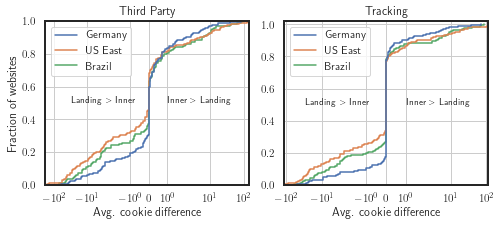

In [ ]:
plot_landing_inner_dif()

#### Section 7 details

In [ ]:
#This function plots the percentage of differences for inner vs. landing page for each VP and for All together.
def print_inner_landing_dif_percentage(df=merged_landing_inner):
    temp = df[df.interaction=="No interaction"]
    temp["more_landing_tp"] = temp['tp_in_land_dif'] < 0
    temp["more_inner_tp"] = temp['tp_in_land_dif'] > 0
    temp["more_landing_tr"] = temp['tr_in_land_dif'] < 0
    temp["more_inner_tr"] = temp['tr_in_land_dif'] > 0
    temp["eq_tp"] = temp['tp_in_land_dif'] == 0
    temp["eq_tr"] = temp['tr_in_land_dif'] == 0
    df_bools = temp[["domain", "more_landing_tp", "more_inner_tp", "more_landing_tr", "more_inner_tr", "eq_tp", "eq_tr", "loc"]]
    df_bools.reset_index(inplace=True, drop=True)
    grouped_domain_loc = df_bools.groupby(["domain", "loc"]).agg("all").reset_index()
    for loc in locations:
        temp_loc = grouped_domain_loc[grouped_domain_loc["loc"]==loc]
        print(f'location: {loc}')
        print(f"{'% of more TP in landing page:':<{37}} {temp_loc[temp_loc.more_landing_tp].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more TP in inner pages:':<{37}} {temp_loc[temp_loc.more_inner_tp].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more tracking in landing page:':<{37}} {temp_loc[temp_loc.more_landing_tr].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more tracking in inner pages:':<{37}} {temp_loc[temp_loc.more_inner_tr].shape[0]/temp_loc.shape[0]*100}")
    
    grouped_domain = grouped_domain_loc.groupby(["domain"]).agg("all").reset_index()
    print(f'\nlocation: All')
    print(f"{'% of more TP in landing page:':<{37}} {grouped_domain[grouped_domain.more_landing_tp].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more TP in inner pages:':<{37}} {grouped_domain[grouped_domain.more_inner_tp].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more tracking in landing page:':<{37}} {grouped_domain[grouped_domain.more_landing_tr].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more tracking in inner pages:':<{37}} {grouped_domain[grouped_domain.more_inner_tr].shape[0]/grouped_domain.shape[0]*100}")         


In [ ]:
print_inner_landing_dif_percentage()

location: Germany
% of more TP in landing page:         28.31858407079646
% of more TP in inner pages:          39.38053097345133
% of more tracking in landing page:   16.371681415929203
% of more tracking in inner pages:    20.79646017699115
location: Sweden
% of more TP in landing page:         27.876106194690266
% of more TP in inner pages:          38.05309734513274
% of more tracking in landing page:   16.8141592920354
% of more tracking in inner pages:    18.58407079646018
location: US East
% of more TP in landing page:         42.47787610619469
% of more TP in inner pages:          30.08849557522124
% of more tracking in landing page:   32.743362831858406
% of more tracking in inner pages:    21.238938053097346
location: US West
% of more TP in landing page:         39.38053097345133
% of more TP in inner pages:          31.858407079646017
% of more tracking in landing page:   28.761061946902654
% of more tracking in inner pages:    22.123893805309734
location: India
% of more T

#### Section 7 details

In [ ]:
#this function shows the number of banners in Inner vs Landing pages
def show_percentage_of_banners_in_land_vs_inner():
    vp_dfs = map_inner_finals.values()
    valid_landing_domains = get_intersection_column(vp_dfs)
    len(valid_landing_domains)
    for loc in locations:
        temp_df = map_inner_finals[loc]
        temp_inner = temp_df[temp_df.is_inner]
        temp_landing = temp_df[~temp_df.is_inner]
        df1 = temp_inner[temp_inner.domain.isin(valid_landing_domains)]
        df2 = temp_landing[temp_landing.domain.isin(valid_landing_domains)]
        print(f"\nLocation: {loc}")
        print(f"% inner pages with banners:   {calc_banners(df1)*100}")
        print(f"% landing pages with banners: {calc_banners(df2)*100}")

In [ ]:
show_percentage_of_banners_in_land_vs_inner()


Location: Germany
% inner pages with banners:   49.93694090042528
% landing pages with banners: 51.36752136752136

Location: Sweden
% inner pages with banners:   51.02800997213668
% landing pages with banners: 51.85185185185185

Location: US East
% inner pages with banners:   25.338026103534244
% landing pages with banners: 22.364672364672362

Location: US West
% inner pages with banners:   28.106760522070683
% landing pages with banners: 25.954415954415953

Location: India
% inner pages with banners:   27.10074791025077
% landing pages with banners: 23.475783475783476

Location: Brazil
% inner pages with banners:   30.937087549494063
% landing pages with banners: 29.287749287749286

Location: South Africa
% inner pages with banners:   26.405631324241092
% landing pages with banners: 24.017094017094017

Location: Australia
% inner pages with banners:   26.739991201055872
% landing pages with banners: 23.61823361823362


## 8. Mobile vs. Desktop

In [ ]:
#This function plot Desktop vs. Mobile agent cookies differences.
def plot_des_mob_dif():
    f, axes = plt.subplots(1, 2, figsize=(double_col_width, single_col_width))
    #f.set_size_inches(single_col_width, single_col_width)
    plt.subplots_adjust(hspace=0.9, wspace=0.3)
    
    temp_df = merged_des_mob[(merged_des_mob.interaction=="No interaction")&(merged_des_mob["loc"].isin(["Germany", "US East", "Brazil"]))].reset_index()
    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#B42C63','#EC5B49']
    bp = sns.ecdfplot(x="tp_des_mob_dif", data=temp_df,hue='loc', ax = axes[0])
    axes[0].set(xlabel="Third Party")
    # axes[0].set(ylim=(0, 1.02), xlabel ='Difference in Tracking cookies: Desktop vs. Mobile', ylabel = "Fraction of websites")
    axes[0].set(xscale="symlog")
    axes[0].text(1, 0.5, u'Desktop $>$ Mobile')
    axes[0].text(-25, 0.5, u"Mobile $>$ Desktop")
    axes[0].legend_.set_title(None)
    axes[0].set(title="Third Party")
    axes[0].set(ylabel= "Fraction of websites",xlabel="Avg. cookie difference")
    plt.ylim(0, 1.02)
    plt.xlim(-111, 115)
    bp.grid()

    bp = sns.ecdfplot(x="tr_des_mob_dif", data=temp_df,hue='loc', ax = axes[1])
    # axes[1].set(ylabel="Average number of first party cookies", xlabel="")
    # axes[1].set(ylim=(0, 1.02), xlabel ='Difference in Tracking cookies: Desktop vs. Mobile', ylabel = "Fraction of websites")
    axes[1].set(xscale="symlog")
    axes[1].text(1, 0.5, u'Desktop $>$ Mobile')
    axes[1].text(-25, 0.5, u"Mobile $>$ Desktop")
    axes[1].legend_.set_title(None)
    axes[1].set(title="Tracking")
    axes[1].set(ylabel= "",xlabel="Avg. cookie difference")
    plt.ylabel(r' ')
    plt.ylim(0, 1.02)
    plt.xlim(-111, 115)
    plt.grid()
    # f.suptitle("Difference in avg. cookies: Mobile vs. Desktop", fontsize=16, y=-0.05, verticalalignment='bottom')
    f.savefig(FIG_DIR+'/mob_vs_des.pdf', bbox_inches='tight')

#### Fig. 8

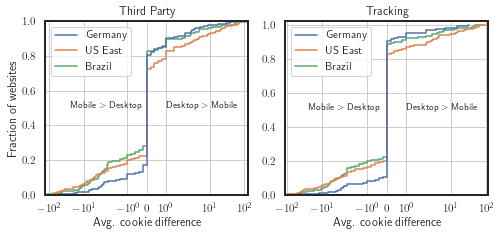

In [ ]:
plot_des_mob_dif()

#### Section 8 details

In [ ]:
#This function plots the percentage of differences for Desktop vs. Mobile agent for each VP and for All together.
def print_des_mob_dif_percentage(df=merged_des_mob):
    temp = df[df.interaction=="No interaction"]
    temp["more_mob_tp"] = temp['tp_des_mob_dif'] < 0
    temp["more_des_tp"] = temp['tp_des_mob_dif'] > 0
    temp["more_mob_tr"] = temp['tr_des_mob_dif'] < 0
    temp["more_des_tr"] = temp['tr_des_mob_dif'] > 0
    temp["eq_tp"] = temp['tp_des_mob_dif'] == 0
    temp["eq_tr"] = temp['tr_des_mob_dif'] == 0
    df_bools = temp[["site_url", "more_des_tp", "more_mob_tp", "more_des_tr", "more_mob_tr", "eq_tp", "eq_tr", "loc"]]
    df_bools.reset_index(inplace=True, drop=True)
    grouped_domain_loc = df_bools.groupby(["site_url", "loc"]).agg("all").reset_index()
    for loc in locations:
        temp_loc = grouped_domain_loc[grouped_domain_loc["loc"]==loc]
        print(f'location: {loc}')
        print(f"{'% of more TP in Desktop:':<{37}} {temp_loc[temp_loc.more_des_tp].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more TP in Mobile:':<{37}} {temp_loc[temp_loc.more_mob_tp].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more tracking in Desktop:':<{37}} {temp_loc[temp_loc.more_des_tr].shape[0]/temp_loc.shape[0]*100}")
        print(f"{'% of more tracking in Mobile:':<{37}} {temp_loc[temp_loc.more_mob_tr].shape[0]/temp_loc.shape[0]*100}")
    
    grouped_domain = grouped_domain_loc.groupby(["site_url"]).agg("all").reset_index()
    print(f'\nlocation: All')
    print(f"{'% of more TP in Desktop:':<{37}} {grouped_domain[grouped_domain.more_des_tp].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more TP in Mobile:':<{37}} {grouped_domain[grouped_domain.more_mob_tp].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more tracking in Desktop:':<{37}} {grouped_domain[grouped_domain.more_des_tr].shape[0]/grouped_domain.shape[0]*100}")
    print(f"{'% of more tracking in Mobile:':<{37}} {grouped_domain[grouped_domain.more_mob_tr].shape[0]/grouped_domain.shape[0]*100}")         


In [ ]:
print_des_mob_dif_percentage()

location: Germany
% of more TP in Desktop:              19.666666666666664
% of more TP in Mobile:               17.0
% of more tracking in Desktop:        9.666666666666666
% of more tracking in Mobile:         10.333333333333334
location: Sweden
% of more TP in Desktop:              21.666666666666668
% of more TP in Mobile:               15.666666666666668
% of more tracking in Desktop:        8.666666666666668
% of more tracking in Mobile:         12.666666666666668
location: US East
% of more TP in Desktop:              27.666666666666668
% of more TP in Mobile:               22.666666666666664
% of more tracking in Desktop:        17.333333333333336
% of more tracking in Mobile:         19.666666666666664
location: US West
% of more TP in Desktop:              25.0
% of more TP in Mobile:               26.0
% of more tracking in Desktop:        14.000000000000002
% of more tracking in Mobile:         23.333333333333332
location: India
% of more TP in Desktop:              21.3333

## 9. Impact of CCPA

In [ ]:
def plot_cookies_comparison_dnsmpi(dnsmpi_10kscale=False, loc="US West"):
    rand = []
    ccpa = []
    if dnsmpi_10kscale:
        ran = ran10k
        ccp = ccp10k
    else: 
        ran = ran1k
        ccp = ccp1k
    for i in ran:
        rand.append("https://"+i)
    for i in ccp:
        ccpa.append("https://"+i)
    dft = map_des_finals[loc].groupby(["site_url", "interaction"]).agg("mean").reset_index()
    temp_rand = dft[(dft.interaction=="No interaction")&dft['site_url'].isin(rand)]
    temp_ccpa = dft[(dft.interaction=="No interaction")&dft['site_url'].isin(ccpa)]
    temp_rand["CCPA"]="Without DNSMPI"
    temp_ccpa["CCPA"]="With DNSMPI"
    temp_ccpa = pd.concat([temp_rand, temp_ccpa])
    
    fig, ax = plt.subplots(figsize=(single_col_width, single_col_width))
    axes1 =sns.ecdfplot(ax=ax, x="count_tp", data=temp_ccpa,hue='CCPA', linewidth=2)
    axes1.set(ylim=(0, 1.02), xlabel =f"Average number of TP cookies ({loc})", ylabel = "Fraction of websites", xscale="log")
    axes1.set_xlim(left=1, right=None)
    axes1.tick_params(axis='x',which='both',bottom=True)
    axes1.legend_.set_title(None)
    plt.grid()

#### Fig. 9

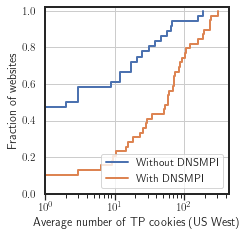

In [ ]:
plot_cookies_comparison_dnsmpi()

#### Section 9 details

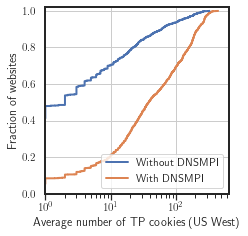

In [ ]:
plot_cookies_comparison_dnsmpi(dnsmpi_10kscale=True)

In [ ]:
# Run dnsmpi_detection() for us_west.
temp = runs['ccpa'].us_west.htmls
temp = temp[temp.domain.isin(runs['ccpa'].polished.domain)]
html_df = temp
dnsmpi_us_west = dnsmpi_detection(html_df)
len(dnsmpi_us_west)

7

In [ ]:
# Run dnsmpi_detection() for us_east.
temp = runs['ccpa'].us_east.htmls
temp = temp[temp.domain.isin(runs['ccpa'].polished.domain)]
html_df = temp
dnsmpi_us_east = dnsmpi_detection(html_df)
len(dnsmpi_us_east)

1

In [ ]:
# Run dnsmpi_detection() for eu_central.
temp = runs['ccpa'].eu_central.htmls
temp = temp[temp.domain.isin(runs['ccpa'].polished.domain)]
html_df = temp
dnsmpi_eu_central = dnsmpi_detection(html_df)
len(dnsmpi_eu_central)

0

In [ ]:
# Run dnsmpi_detection() for ap_south.
temp = runs['ccpa'].ap_south.htmls
temp = temp[temp.domain.isin(runs['ccpa'].polished.domain)]
html_df = temp
dnsmpi_ap_south = dnsmpi_detection(html_df)
len(dnsmpi_ap_south)

0

## Appendix

In [ ]:
def extract_words(text: str):
    if not text:
        return []
    delimeter = ';|,|\*|\n|\s+|\!|\&|-|_'
    # words = re.findall(r'[A-Za-z]+', text)
    words = [word.capitalize() for word in re.split(delimeter, text)]
    
    if len(words) > 4:
        return []
    return words

def get_words_list_in_btn(lang="de"):
    extract_mode = 1   # 0.all 1.text 2.class 3.id
    mode = None
    flag = False
    banners_with_btn = 0
    num_banners = 0
    words_en = []
    words_lang = []
    domains_with_help = []
    domains_with_sth = []
    no_btn = []
    htmls = runs["words-extraction"].eu_north.htmls[runs["words-extraction"].eu_north.htmls.visit_id<10000]
    visits = runs["words-extraction"].eu_north.visits
    num_lang = 0
    with_euro = []
    with_dollar = []
    print('number of total banners: ' + str(len(htmls)))

    for index, row in htmls.iterrows():
        try:
            flag = False
            soup = bs(row.html, features="html")
            tx = soup.get_text()
            for b in soup.find_all('button'):
                flag = True
                words_to_add = [row.domain]
                if row.visit_id == 7493:
                    j = 10

                if extract_mode == 1 or extract_mode == 0:
                    words_to_add = extract_words(b.getText())
                    mode = "text"
                if extract_mode == 2 or extract_mode == 0:
                    if b.has_attr('class'):
                        for c in b['class']:
                            class_words = extract_words(c)
                            words_to_add.extend(class_words)
                    mode = "class"
                if extract_mode == 3 or extract_mode == 0:
                    if b.has_attr('id'):
                        class_words = extract_words(b['id'])
                        words_to_add.extend(class_words)
                    mode = "id"
                if 'Help' in words_to_add:
                    domains_with_help.append(row.domain)
                    continue

                if lang == 'all':
                    if 'Purposes' in words_to_add:
                        domains_with_sth.append((row.visit_id, row.domain))
                    words.extend(words_to_add)
                elif "en" in visits.loc[visits['visit_id'] == row.visit_id].iloc[0].lang:
                    if 'Vendor' in words_to_add:
                        domains_with_sth.append((row.visit_id, row.domain))
                    words_en.extend(words_to_add)
                elif lang in visits.loc[visits['visit_id'] == row.visit_id].iloc[0].lang:
                    if 'Vendor' in words_to_add:
                        domains_with_sth.append((row.visit_id, row.domain))
                    words_lang.extend(words_to_add)
            if lang == 'all':
                num_lang += 1
            elif lang in visits.loc[visits['visit_id'] == row.visit_id].iloc[0].lang:
                num_lang += 1
        except Exception as E:

            pass
        if flag:
            banners_with_btn += 1
        else:
            no_btn.append(row.domain)
        num_banners += 1

    return pd.Series(words_en), pd.Series(words_lang)


In [ ]:
ser_en, ser_lang = get_words_list_in_btn(lang="de")

number of total banners: 4404


In [ ]:
def plot_words_freq(word_series=ser_en):
    words_to_plot = ["Accept", "Settings", "Reject", "Options", "Agree", "Preferences", "Close", "Confirm", "Consent", "Allow", "Continue", "Decline", "Got", "Disagree", "Enable", "Deny"]
    words_to_plot = ["Accept", "Settings", "Reject", "Options", "Agree", "Preferences", "Close", "Confirm", "Consent", "Allow", "Continue", "Decline", "Got", "Disagree", "Enable", "Deny"]
    vc1_en = word_series.value_counts()
    vc = vc1_en[words_to_plot]
    words_to_plot[words_to_plot.index("Got")] = "Got it"
    got_it_freq = vc["Got"]
    vc = vc.reindex(words_to_plot, fill_value=got_it_freq)
    words_to_plot.insert(0, '')
    vc = vc.reindex(words_to_plot, fill_value=0)
    ax = vc.cumsum().plot.line(figsize=(single_col_width, single_col_width), marker='h', markerfacecolor='lightgreen', markeredgewidth=1,
             markersize=3, markevery=1)
    x = [list(vc.index).index(word) for word in vc.index]
    y = list(vc.cumsum())
    i = 0
    for x,y in zip(x,y):
        _x = -5 - len(words_to_plot[x]) * 1.2
        _y = 2
        ax.annotate(words_to_plot[x], # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(_x,_y), # distance from text to points (x,y)
                     ha='center',
                     rotation=-20-i) # horizontal alignment can be left, right or center
        i = i + 1.7
    ax.axes.xaxis.set_ticklabels([])
    ax.set(xlabel="Words", ylabel="Cumulative frequency")
    ax.set_ylim(0, 5300)
    ax.set_xlim(-2.1, 16.33)
    ax.tick_params(bottom=False, top=False, left=True, right=False)
    ax.figure.savefig(FIG_DIR+'/words_freq_en.pdf', bbox_inches='tight')

#### Fig. 10

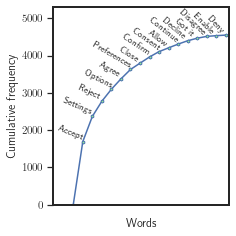

In [ ]:
plot_words_freq()